### INTEGRANTES:

* John Mario Micolta Garzón
* José Luis Gamarra Palacios
    

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from math import sqrt
import math

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from bayes_opt import BayesianOptimization

In [2]:
def r2adj(y_real, y_pred, numFeatures):
    return 1 - (1-r2_score(y_real, y_pred))*(len(y_real)-1) / (len(y_real) - numFeatures - 1)

In [3]:
df = pd.read_csv("datos_clima.csv")

In [4]:
df.head()

,Unnamed: 0,PresionAire (mbar),PresionVapor (mbar),HumedadRelativa (%),ConcentracionVapor (mmol/mol),DensidadAire (g/m**3),DireccionViento (grado),Temperatura (C)
0,01.01.2010,970.000208,4.348264,94.777778,4.483333,1252.657986,64.320278,-3.863403
1,02.01.2010,985.915486,3.793889,91.520833,3.849444,1280.425208,238.964236,-5.296667
2,03.01.2010,990.590625,4.049236,92.757639,4.087569,1283.044514,132.256944,-4.605903
3,04.01.2010,988.882014,3.467292,90.650694,3.505417,1289.135417,145.993472,-6.284306
4,05.01.2010,981.295347,2.385556,85.181528,2.431111,1299.386597,165.373125,-10.286736


---

In [5]:
df.columns

Index(['Unnamed: 0', 'PresionAire (mbar)', 'PresionVapor (mbar)',
       'HumedadRelativa (%)', 'ConcentracionVapor (mmol/mol)',
       'DensidadAire (g/m**3)', 'DireccionViento (grado)', 'Temperatura (C)'],
      dtype='object')

In [6]:
colnames = ['Fecha', 'PresionAire (mbar)', 'PresionVapor (mbar)',
       'HumedadRelativa (%)', 'ConcentracionVapor (mmol/mol)',
       'DensidadAire (g/m**3)', 'DireccionViento (grado)', 'Temperatura (C)']
df.columns = colnames

In [7]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Fecha,2193,2190,21.03.2014,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PresionAire (mbar),2193,NaN,NaN,NaN,989.292,7.91317,951.558,984.379,989.457,994.386,1011.2
PresionVapor (mbar),2193,NaN,NaN,NaN,9.52868,4.10651,1.29861,6.28368,8.90917,12.2335,23.8035
HumedadRelativa (%),2193,NaN,NaN,NaN,75.8395,11.5927,38.5029,67.5226,76.7469,84.4424,100
ConcentracionVapor (mmol/mol),2193,NaN,NaN,NaN,9.63515,4.15792,1.28799,6.3441,8.98326,12.3573,24.1188
DensidadAire (g/m**3),2193,NaN,NaN,NaN,1216.12,37.6223,1133.43,1188.26,1212.65,1242.08,1368.36
DireccionViento (grado),2193,NaN,NaN,NaN,174.25,54.4839,22.5692,141.965,187.765,211.457,279.368
Temperatura (C),2193,NaN,NaN,NaN,9.46232,7.86111,-16.5831,3.89944,9.71771,15.3599,29.4507


In [8]:
fechas = df.loc[:,'Fecha']

In [9]:
df_ori = df.copy(deep=True)

In [10]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2193 entries, 0 to 2192
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Fecha                          2193 non-null   object 
 1   PresionAire (mbar)             2193 non-null   float64
 2   PresionVapor (mbar)            2193 non-null   float64
 3   HumedadRelativa (%)            2193 non-null   float64
 4   ConcentracionVapor (mmol/mol)  2193 non-null   float64
 5   DensidadAire (g/m**3)          2193 non-null   float64
 6   DireccionViento (grado)        2193 non-null   float64
 7   Temperatura (C)                2193 non-null   float64
dtypes: float64(7), object(1)
memory usage: 137.2+ KB


# Parte 1: Modelos Shallow

Creación del dataset de corte transversal para SVR y Redes sencillas

Función para crear variables nuevas a partir de las series. Se busca el valor mínimo, máximo, promedio, media de los últimos 3 días y mínimo de los últimos 7 días según el número de "pasos" a elegir.

In [11]:
def split_corte_transversal(sequences, n_steps, var, label):

    X = pd.DataFrame()
    y = pd.DataFrame()
    
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences)-1:
            break
        #seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, 7]
        seq_x = sequences[i:end_ix, :]
        minn = seq_x[:, var].min()
        maxx = seq_x[:, var].max()
        meann = seq_x[:, var].mean()
        min3Day = seq_x[3::-1, var].mean()
        min7Day = seq_x[7::-1, var].min()
        
        X = X.append({
            'min' + label : minn,
            'max' + label : maxx,
            'mean' + label : meann,
            'min3Day' + label : min3Day,
            'min7Day' + label : min7Day,
        }, ignore_index = True)
        
        y = y.append({
            'Temperatura' : sequences[end_ix, 7]
        }, ignore_index = True)

    return X, y

Función para generar el dataset de corte transversal a partir de las series. Se crea para facilitar la reproducción del código en distintas zonas del notebook y buscar la mejor ventana (n_steps) utilizando la optimización bayesiana

In [12]:
def corteTransversal(n_steps):
    presionAire, Temperatura = split_corte_transversal(df.to_numpy(), n_steps, 1, 'PresionAire')
    presionVapor, _ = split_corte_transversal(df.to_numpy(), n_steps, 2, 'PresionVapor')
    HumedadRelativa, _ = split_corte_transversal(df.to_numpy(), n_steps, 3, 'HumedadRelativa')
    ConcentracionVapor, _ = split_corte_transversal(df.to_numpy(), n_steps, 4, 'ConcentracionVapor')
    DensidadAire, _ = split_corte_transversal(df.to_numpy(), n_steps, 5, 'DensidadAire')
    DireccionViento, _ = split_corte_transversal(df.to_numpy(), n_steps, 6, 'DireccionViento')
    TemperaturaCT, _ = split_corte_transversal(df.to_numpy(), n_steps, 7, 'Temperatura')
    
    data = pd.concat([presionAire.reset_index(drop=True), 
        presionVapor, 
        HumedadRelativa, 
        ConcentracionVapor, 
        DensidadAire,
        DireccionViento,
        TemperaturaCT,
        Temperatura], axis=1)
    return data

Las tareas de split train/test las realizamos con la siguiente función. Hacemos suffle a la partición que se usa para entrenamiento. 

In [13]:
def splitData(data):
    np.random.seed(1234)

    periodos_test = round(len(data) * 0.2)
    periodos_train = len(data) - periodos_test
    
    train = data.iloc[:periodos_train,:]
    test = data.iloc[periodos_train:,:]
    
    train = shuffle(train)
    
    X_train = train.iloc[:, :-1]
    X_test = test.iloc[:, :-1]
    y_train = train.iloc[:, len(df.columns) - 1]
    y_test = test.iloc[:, len(df.columns) - 1]
    
    return X_train, y_train, X_test, y_test

# SVR

Estimación y evaluación de los modelos SVR.

## Model SVR sin estandarizar las variables

Estimación de un modelo SVR sin las variables estandarizadas.

Buscamos los mejores hiperparámetros (C, gamma, tol y epsilon) para el SVR y el mejor tamaño de ventana (n_steps).

Tener en cuenta que parte del pretratamiento de los datos lo hacemos dentro de las funciones, esto con el objetivo de simular un pipeline dado que el que provee scikit-learn no está integrado con BayesianOptimization.

In [14]:
def buildModelSVR1(C, gamma, tol, epsilon, n_steps): 
    np.random.seed(1234)  
    
    n_steps = int(round(n_steps))
    
    # Corte transversal
    data = corteTransversal(n_steps) #muy leeeento
    # Split
    X_train, y_train, X_test, y_test = splitData(data)

    #Estimación del modelo
    model = SVR(C = C, kernel = 'rbf', gamma = gamma, tol = tol, epsilon = epsilon)
    model.fit(X_train, y_train) 
    y_pred = model.predict(X_test)   
    print("Evaluando con C ({}), gamma ({}), tolerancia ({}), epsilon ({}) y una ventana de ({}).".format(C, gamma, tol, epsilon, n_steps))     
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    return -rmse

# Establecemos los límites donde buscará optimizador
pbounds = {
    'C': (0.001, 100), 
    'gamma' : (0.001, 100),
    'tol' : (0.001, 5),
    'epsilon' : (0.001, 5),
    'n_steps' : (1, 200)
}

optimizer = BayesianOptimization(
    f = buildModelSVR1,
    pbounds = pbounds,
    random_state = 1,
    verbose = 1
)

In [15]:
%%time 
optimizer.maximize(
    init_points=3,
    n_iter=10,
)

|   iter    |  target   |     C     |  epsilon  |   gamma   |  n_steps  |    tol    |
-------------------------------------------------------------------------------------
Evaluando con C (41.702783448252696), gamma (0.012437367359671318), tolerancia (0.7346326981947481), epsilon (3.601902142717348) y una ventana de (61).
Evaluando con C (9.23476713828501), gamma (34.556727143577724), tolerancia (2.694544853282781), epsilon (0.9321147966769768) y una ventana de (80).
Evaluando con C (41.92003224581507), gamma (20.44602052090201), tolerancia (0.1379105783964329), epsilon (3.4264122824834002) y una ventana de (176).
Evaluando con C (39.91804495602341), gamma (0.4256865922717722), tolerancia (1.4710393186255117), epsilon (2.549472995946248) y una ventana de (58).
|  4        | -3.853    |  39.92    |  2.549    |  0.4257   |  58.38    |  1.471    |
Evaluando con C (30.266347422312222), gamma (0.06788944255241798), tolerancia (2.3729829334474966), epsilon (1.7527185253370048) y una ventana 

In [16]:
optimizer.max

{'target': -1.5953289179379193,
 'params': {'C': 14.639162699147741,
  'epsilon': 0.001,
  'gamma': 0.001,
  'n_steps': 1.0,
  'tol': 5.0}}

Con este modelo obtenemos un rmse de **1.59**

A continuación, realizamos una búsqueda más local teniendo en cuenta los mejores hiperparámetros encontrados con el método de optimización bayesiana.

In [17]:
pbounds = {
    'C': (10, 18), 
    'gamma' : (0.0001, 1),
    'tol' : (4, 8),
    'epsilon' : (0.0001, 1),
    'n_steps' : (1, 10)
}
optimizer.set_bounds(pbounds)

In [18]:
optimizer.maximize(
    n_iter = 10
)

|   iter    |  target   |     C     |  epsilon  |   gamma   |  n_steps  |    tol    |
-------------------------------------------------------------------------------------
Evaluando con C (15.363740081427217), gamma (0.558733959462907), tolerancia (4.792405956339515), epsilon (0.41736307188689026) y una ventana de (2).
Evaluando con C (16.405956549404294), gamma (0.3134928357414269), tolerancia (7.505556609184153), epsilon (0.9682647495618256) y una ventana de (7).
Evaluando con C (17.15685330803078), gamma (0.039150877754559076), tolerancia (7.512570013717653), epsilon (0.08513570694864094) y una ventana de (3).
Evaluando con C (10.7867746706644), gamma (0.9578937411974869), tolerancia (6.767508455801893), epsilon (0.42116551424255166) y una ventana de (6).
Evaluando con C (12.524125048048504), gamma (0.8346422093301832), tolerancia (7.00057725977987), epsilon (0.6865322775888155) y una ventana de (1).
Evaluando con C (13.07678487554709), gamma (0.030794175524119723), tolerancia (4.24

In [19]:
optimizer.max

{'target': -1.5953289179379193,
 'params': {'C': 14.639162699147741,
  'epsilon': 0.001,
  'gamma': 0.001,
  'n_steps': 1.0,
  'tol': 5.0}}

Seguimos obteniendo el mismo rmse (**1.59**). Guardamos esta configuración.

In [20]:
hiperpSVR1 = optimizer.max
hiperpSVR1

{'target': -1.5953289179379193,
 'params': {'C': 14.639162699147741,
  'epsilon': 0.001,
  'gamma': 0.001,
  'n_steps': 1.0,
  'tol': 5.0}}

Guardamos los mejores hiperparámetros y el rmse obtenido.

In [21]:
resultsSVR = pd.DataFrame()

In [22]:
resultsSVR = resultsSVR.append(
    {
        'model': 'Normal',
        'RMSE' : optimizer.max['target'],
        'C' : optimizer.max['params']['C'],
        'epsilon' : optimizer.max['params']['epsilon'],
        'gamma' : optimizer.max['params']['gamma'],
        'tol' : optimizer.max['params']['tol'],
        'n_steps' : optimizer.max['params']['n_steps'],
    }, ignore_index = True)

resultsSVR

,C,RMSE,epsilon,gamma,model,n_steps,tol
0,14.639163,-1.595329,0.001,0.001,Normal,1.0,5.0


## Model SVR con las variables estandarizadas

A continuación, estimamos un modelo SVR con las variables estandarizadas.

Buscamos los mejores hiperparámetros (C, gamma, tol y epsilon) para el SVR y el mejor tamaño de ventana (n_steps).

En este caso, estandarizamos los datos de entrenamiento y de test por separado para evitar data leakage.

In [23]:
def buildModelSVR2(C, gamma, tol, epsilon, n_steps): 
    np.random.seed(1234) 
    
    n_steps = int(round(n_steps))
    
    # Corte transversal
    data = corteTransversal(n_steps)
    # Split
    X_train, y_train, X_test, y_test = splitData(data)
    
    #Pretratamiento de los datos
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.fit_transform(X_test)

    #Estimación del modelo
    model = SVR(C = C, kernel = 'rbf', gamma = gamma, tol = tol, epsilon = epsilon)
    model.fit(X_train_std, y_train)  
    y_pred = model.predict(X_test_std)   
    print("Evaluando con C ({}), gamma ({}), tolerancia ({}), epsilon ({}) y una ventana de ({}).".format(C, gamma, tol, epsilon, n_steps))     
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    print('RMSE {}'.format(rmse))
    return -rmse

# Establecemos los límites donde buscará optimizador
pbounds = {
    'C': (0.001, 100), 
    'gamma' : (0.001, 100),
    'tol' : (0.001, 5),
    'epsilon' : (0.001, 5),
    'n_steps' : (1, 200)
}

optimizer = BayesianOptimization(
    f = buildModelSVR2,
    pbounds = pbounds,
    random_state = 1,
    verbose = 1
)

In [24]:
%%time 
optimizer.maximize(
    init_points=3,
    n_iter=10,
)

|   iter    |  target   |     C     |  epsilon  |   gamma   |  n_steps  |    tol    |
-------------------------------------------------------------------------------------
Evaluando con C (41.702783448252696), gamma (0.012437367359671318), tolerancia (0.7346326981947481), epsilon (3.601902142717348) y una ventana de (61).
RMSE 1.7780550875872527
Evaluando con C (9.23476713828501), gamma (34.556727143577724), tolerancia (2.694544853282781), epsilon (0.9321147966769768) y una ventana de (80).
RMSE 3.9399436505700427
Evaluando con C (41.92003224581507), gamma (20.44602052090201), tolerancia (0.1379105783964329), epsilon (3.4264122824834002) y una ventana de (176).
RMSE 4.018323880165401
Evaluando con C (39.91804495602341), gamma (0.4256865922717722), tolerancia (1.4710393186255117), epsilon (2.549472995946248) y una ventana de (58).
RMSE 3.794225058196921
Evaluando con C (29.99056338757198), gamma (58.614189330878276), tolerancia (2.371513729097623), epsilon (2.2928551371511277) y una ven

In [25]:
optimizer.max

{'target': -1.7780550875872527,
 'params': {'C': 41.702783448252696,
  'epsilon': 3.601902142717348,
  'gamma': 0.012437367359671318,
  'n_steps': 61.16418195373611,
  'tol': 0.7346326981947481}}

El rmse para este modelo es de **1.77**, siendo un poco mayor (1.59) que el del modelo entrenado sin estandarizar las variables. Procedemos a tratar de encontrar mejores hiperparámetros.

In [26]:
pbounds = {
    'C': (35, 45), 
    'gamma' : (0.01, 1),
    'tol' : (0.1, 1),
    'epsilon' : (2, 5),
    'n_steps' : (50, 70)
}
optimizer.set_bounds(pbounds)

In [28]:
optimizer.maximize(
    n_iter = 10
)

|   iter    |  target   |     C     |  epsilon  |   gamma   |  n_steps  |    tol    |
-------------------------------------------------------------------------------------
Evaluando con C (41.70467510178402), gamma (0.5631029301612941), tolerancia (0.2782913401763909), epsilon (3.251914407101381) y una ventana de (53).
RMSE 3.771768115676592
Evaluando con C (43.00744568675537), gamma (0.3202899363776504), tolerancia (0.8887502370664345), epsilon (4.904784727158193) y una ventana de (64).
RMSE 3.8172968585118237
Evaluando con C (43.94606663503848), gamma (0.04866423540055354), tolerancia (0.8903282530864718), epsilon (2.2551326341093336) y una ventana de (53).
RMSE 1.5004997218259997
|  16       | -1.5      |  43.95    |  2.255    |  0.04866  |  53.4     |  0.8903   |
Evaluando con C (35.9834683383305), gamma (0.9583106348489969), tolerancia (0.722689402555426), epsilon (3.2633228750151564) y una ventana de (61).
RMSE 3.8708471492186685
Evaluando con C (38.15515631006063), gamma (0.8362

In [29]:
optimizer.max

{'target': -1.5004997218259997,
 'params': {'C': 43.94606663503848,
  'epsilon': 2.2551326341093336,
  'gamma': 0.04866423540055354,
  'n_steps': 53.39660839129138,
  'tol': 0.8903282530864718}}

Después de la búsqueda local, obtenemos un rmse de **1.50**, siendo más bajo que el anterior (antes de la búsqueda local) y que el del modelo sin las variables estandarizadas. Procedemos a guardar la configuración.

In [30]:
hiperpSVR2 = optimizer.max
hiperpSVR2

{'target': -1.5004997218259997,
 'params': {'C': 43.94606663503848,
  'epsilon': 2.2551326341093336,
  'gamma': 0.04866423540055354,
  'n_steps': 53.39660839129138,
  'tol': 0.8903282530864718}}

In [31]:
resultsSVR = resultsSVR.append(
    {
        'model': 'Estandarizado',
        'RMSE' : optimizer.max['target'],
        'C' : optimizer.max['params']['C'],
        'epsilon' : optimizer.max['params']['epsilon'],
        'gamma' : optimizer.max['params']['gamma'],
        'tol' : optimizer.max['params']['tol'],
        'n_steps' : optimizer.max['params']['n_steps'],
    }, ignore_index = True)
resultsSVR

,C,RMSE,epsilon,gamma,model,n_steps,tol
0,14.639163,-1.595329,0.001000,0.001000,Normal,1.000000,5.000000
1,43.946067,-1.500500,2.255133,0.048664,Estandarizado,53.396608,0.890328


## Model SVR #3 - PCA

Al ser el número de componentes un hiperparámetro, utilizamos la optimización bayesiana para encontrar el mejor valor para éste. 

In [38]:
def buildModelSVR3(C, gamma, tol, epsilon, n_steps, n_componentes):
    
    np.random.seed(1234)
    
    n_steps = int(round(n_steps))
    n_componentes = int(round(n_componentes))
    
    # Corte transversal
    data = corteTransversal(n_steps)
    # Split
    X_train, y_train, X_test, y_test = splitData(data)
    
    # Pretratamiento de los datos
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.fit_transform(X_test)
    
    # PCA
    pca = PCA(n_componentes)
    pca2 = PCA(n_componentes)
    X_train_PCA = pca.fit_transform(X_train_std)
    X_test_PCA = pca2.fit_transform(X_test_std)
    
    # Estimación del modelo
    model = SVR(C = C, kernel = 'rbf', gamma = gamma, tol = tol, epsilon = epsilon)
    model.fit(X_train_PCA, y_train)  
    y_pred = model.predict(X_test_PCA)   
    print("Evaluando con C ({}), gamma ({}), tolerancia ({}), epsilon ({}) y una ventana de ({}).".format(C, gamma, tol, epsilon, n_steps))     
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    return -rmse

# Establecemos los límites donde buscará opt
pbounds = {
    'C': (0.001, 100), 
    'gamma' : (0.001, 100),
    'tol' : (0.001, 5),
    'epsilon' : (0.001, 5),
    'n_steps' : (1, 200),
    'n_componentes' : (1, 30)
}

optimizer = BayesianOptimization(
    f = buildModelSVR3,
    pbounds = pbounds,
    random_state = 1,
    verbose = 1
)

In [39]:
%%time 
optimizer.maximize(
    init_points=3,
    n_iter=10,
)

|   iter    |  target   |     C     |  epsilon  |   gamma   | n_comp... |  n_steps  |    tol    |
-------------------------------------------------------------------------------------------------
Evaluando con C (41.702783448252696), gamma (0.012437367359671318), tolerancia (0.4626006352492202), epsilon (3.601902142717348) y una ventana de (30).
Evaluando con C (18.626834877555712), gamma (39.67735065559276), tolerancia (3.4264122824834002), epsilon (1.7284580744881954) y una ventana de (84).
|  2        | -3.911    |  18.63    |  1.728    |  39.68    |  16.63    |  84.42    |  3.426    |
Evaluando con C (20.44602052090201), gamma (2.739731932199418), tolerancia (2.793890452400312), epsilon (4.390709064518336) y una ventana de (84).
|  3        | -3.888    |  20.45    |  4.391    |  2.74     |  20.44    |  84.04    |  2.794    |
Evaluando con C (13.930977831201352), gamma (42.444322186495285), tolerancia (0.5146800628069474), epsilon (1.886709220769921) y una ventana de (85).
Evaluando

In [40]:
optimizer.max

{'target': -3.7970469272180902,
 'params': {'C': 100.0,
  'epsilon': 4.95991177691458,
  'gamma': 45.49631299745204,
  'n_componentes': 1.0,
  'n_steps': 197.3355944854622,
  'tol': 3.115110687217511}}

El RMSE obtenido con este modelo haciendo uso de la estandarización y PCA (**3.79**) es mayor que el menor obtenido hasta ahora (1.50). Guardamos los parámetros.

In [41]:
hiperpSVR3 = optimizer.max
hiperpSVR3

{'target': -3.7970469272180902,
 'params': {'C': 100.0,
  'epsilon': 4.95991177691458,
  'gamma': 45.49631299745204,
  'n_componentes': 1.0,
  'n_steps': 197.3355944854622,
  'tol': 3.115110687217511}}

In [42]:
resultsSVR = resultsSVR.append(
    {
        'model' : 'PCA',
        'RMSE' : optimizer.max['target'],
        'C' : optimizer.max['params']['C'],
        'epsilon' : optimizer.max['params']['epsilon'],
        'gamma' : optimizer.max['params']['gamma'],
        'tol' : optimizer.max['params']['tol'],
        'n_steps' : optimizer.max['params']['n_steps'],
    }, ignore_index = True)

In [43]:
resultsSVR

,C,RMSE,epsilon,gamma,model,n_steps,tol
0,14.639163,-1.595329,0.001000,0.001000,Normal,1.000000,5.000000
1,43.946067,-1.500500,2.255133,0.048664,Estandarizado,53.396608,0.890328
2,100.000000,-3.797047,4.959912,45.496313,PCA,197.335594,3.115111


## Model SVR #4 - Lasso

In [45]:
from sklearn.linear_model import Ridge, Lasso

Construimos el modelo SVR aplicando Lasso. Buscamos los mejores hiperparámetros para el modelo SVR al igual que Lasso (max_iter, tol_lasso, alpha_lasso). Internamente seleccionamos las variables que sean distintas de 0. 

In [44]:
def buildModelSVR4(C, gamma, tol, epsilon, n_steps, tol_lasso, alpha_lasso, max_iter):
    
    np.random.seed(1234)
    
    n_steps = int(round(n_steps))
    max_iter = int(round(max_iter))
  
    # Corte transversal
    data = corteTransversal(n_steps)
    
    # Split
    X_train, y_train, X_test, y_test = splitData(data)
    
    # Pretratamiento de los datos
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.fit_transform(X_test)
    
    lasso = Lasso(fit_intercept = True, normalize = False,  max_iter = max_iter, tol = tol_lasso, alpha = alpha_lasso)
    lasso.fit(X_train, y_train)
    
    # Buscamos las diferentes de cero
    significativas = lasso.coef_ != 0
    
    # Descartamos las diferentes de cero
    X_train_lasso = X_train.values[:,significativas]
    X_test_lasso = X_test.values[:,significativas]

    model = SVR(C = C, kernel = 'rbf', gamma = gamma, tol = tol, epsilon = epsilon)
    model.fit(X_train_lasso, y_train)  
    y_pred = model.predict(X_test_lasso)   
    print("Evaluando con C ({}), gamma ({}), tolerancia ({}), epsilon ({}) y una ventana de ({}).".format(C, gamma, tol, epsilon, n_steps))     
    mse = mean_squared_error(y_test, y_pred)
    rmse = math.sqrt(mse)
    return -rmse

# Establecemos los límites donde buscará opt
pbounds = {
    'C': (0.001, 100), 
    'gamma' : (0.001, 100),
    'tol' : (0.001, 5),
    'epsilon' : (0.001, 5),
    'n_steps' : (1, 200),
    'tol_lasso': (0.001, 1), 
    'alpha_lasso' : (-2, 2),
    'max_iter' : (1, 1000), 
}

optimizer = BayesianOptimization(
    f = buildModelSVR4,
    pbounds = pbounds,
    random_state = 1,
    verbose = 1
)

In [46]:
%%time 
optimizer.maximize(
    init_points=3,
    n_iter=10,
)

|   iter    |  target   |     C     | alpha_... |  epsilon  |   gamma   | max_iter  |  n_steps  |    tol    | tol_lasso |
-------------------------------------------------------------------------------------------------------------------------
|  11       | -3.623    |  45.05    | -0.8575   |  0.9742   |  24.33    |  144.4    |  16.15    |  0.2506   |  0.5144   |
Wall time: 8min 22s


In [47]:
optimizer.max

{'target': -3.6225590058313877,
 'params': {'C': 45.05088207712093,
  'alpha_lasso': -0.8575356523175901,
  'epsilon': 0.9742437343771132,
  'gamma': 24.333794470537693,
  'max_iter': 144.35703998001796,
  'n_steps': 16.150887554913258,
  'tol': 0.25057292718571933,
  'tol_lasso': 0.5143668604694723}}

El RMSE obtenido es mayor que el menor obtenido hasta ahora. Procedemos a realizar búsquedas locales.

In [48]:
pbounds = {
    'C': (40, 50), 
    'gamma' : (20, 28),
    'tol' : (0.20, 0.30),
    'epsilon' : (0.8, 1.5),
    'n_steps' : (10, 20),
    'tol_lasso': (0.4, 1), 
    'alpha_lasso' : (-1, 1),
    'max_iter' : (100, 200), 
}
optimizer.set_bounds(pbounds)

In [49]:
optimizer.maximize(
    n_iter = 10
)

|   iter    |  target   |     C     | alpha_... |  epsilon  |   gamma   | max_iter  |  n_steps  |    tol    | tol_lasso |
-------------------------------------------------------------------------------------------------------------------------
|  16       | -3.612    |  49.89    |  0.4963   |  0.9963   |  26.31    |  110.3    |  14.48    |  0.2909   |  0.5762   |
|  17       | -3.603    |  42.88    | -0.7399   |  0.8136   |  25.43    |  121.2    |  12.66    |  0.2492   |  0.432    |
|  19       | -3.583    |  50.0     | -1.0      |  0.8      |  20.0     |  200.0    |  10.0     |  0.2      |  1.0      |
|  23       | -3.583    |  50.0     | -1.0      |  0.8      |  20.0     |  187.0    |  10.0     |  0.3      |  0.4      |


In [50]:
optimizer.max

{'target': -3.5833677009880587,
 'params': {'C': 50.0,
  'alpha_lasso': -1.0,
  'epsilon': 0.8,
  'gamma': 20.0,
  'max_iter': 187.02287388638072,
  'n_steps': 10.0,
  'tol': 0.3,
  'tol_lasso': 0.4}}

El RMSE obtenido con la búsqueda local sigue siendo más alto que el menor obtenido hasta ahora (Modelo solo con estandarización).

In [51]:
hiperpSVR4 = optimizer.max

In [52]:
resultsSVR = resultsSVR.append(
    {
        'model' : 'LASSO',
        'RMSE' : optimizer.max['target'],
        'C' : optimizer.max['params']['C'],
        'epsilon' : optimizer.max['params']['epsilon'],
        'gamma' : optimizer.max['params']['gamma'],
        'tol' : optimizer.max['params']['tol'],
        'n_steps' : optimizer.max['params']['n_steps'],
    }, ignore_index = True)

In [53]:
resultsSVR

,C,RMSE,epsilon,gamma,model,n_steps,tol
0,14.639163,-1.595329,0.001000,0.001000,Normal,1.000000,5.000000
1,43.946067,-1.500500,2.255133,0.048664,Estandarizado,53.396608,0.890328
2,100.000000,-3.797047,4.959912,45.496313,PCA,197.335594,3.115111
3,50.000000,-3.583368,0.800000,20.000000,LASSO,10.000000,0.300000


# Redes neuronales artificiales tradicionales

Para crear la red neuronal artificial tradicional vamos a utilizar tensorflow 2x y no scikit-learn para poder aprovechar la potencia de la GPU y obtener menores tiempos de entrenamiento.

In [54]:
import tensorflow as tf
print(tf.__version__)
import tensorflow.keras as keras
print(keras.__version__)
from tensorflow.keras import models, layers

2.1.0
2.2.4-tf


Creamos una red neuronal con 2 capas ocultas y buscamos la mejor cantidad de neuronas para cada una. Así mismo, buscamos las épocas, el tamaño del batch y el tamaño de la ventana. En este caso se entrena la red con las variables estandarizadas.

In [55]:
def buildModelNN(hidden1, hidden2, epochs, batch_size, n_steps):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    np.random.seed(1234) 

    hidden1 = int(round(hidden1))
    hidden2 = int(round(hidden2))
    epochs = int(round(epochs))
    batch_size = int(round(batch_size))
    n_steps = int(round(n_steps))
    
    # Corte transversal
    data = corteTransversal(n_steps)
    # Split
    X_train, y_train, X_test, y_test = splitData(data)
    
    #Pretratamiento de los datos
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.fit_transform(X_test)

    modelNN = models.Sequential()
    modelNN.add(layers.Dense(units = hidden1, activation = 'relu', input_shape = (len(data.columns)-1,)))
    modelNN.add(layers.Dense(units = hidden2, activation = 'relu'))
    modelNN.add(layers.Dense(units = 1, activation = 'linear'))
    
    modelNN.compile(optimizer = 'adam', loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    history = modelNN.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=0.1, verbose = 1)    
    y_pred = modelNN.predict(X_test)
    
    #print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)), 
    #  ", MAE:", mean_absolute_error(y_test, y_pred), 
    #  ", R2:", r2_score(y_test, y_pred), "\n")
    
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #mse = mean_squared_error(y_test, y_pred)
    
    return -rmse

# Establecemos los límites donde buscará opt
pbounds = {
    'hidden1': (2, 1000), 
    'hidden2' : (2, 1000),
    'epochs' : (1, 100),
    'batch_size' : (1, len(df_ori)),
    'n_steps' : (1, 200)
}

optimizer = BayesianOptimization(
    f = buildModelNN,
    pbounds = pbounds,
    random_state = 1,
    verbose = 1
)

In [56]:
%%time 
optimizer.maximize(
    init_points=3,
    n_iter=10,
)

|   iter    |  target   | batch_... |  epochs   |  hidden1  |  hidden2  |  n_steps  |
-------------------------------------------------------------------------------------
Train on 1557 samples, validate on 173 samples
Epoch 1/72
1557/1557 [==============================] - 2s 1ms/sample - loss: 117.4019 - root_mean_squared_error: 10.8352 - val_loss: 22.1830 - val_root_mean_squared_error: 4.7099
Epoch 2/72
1557/1557 [==============================] - 0s 11us/sample - loss: 37.0395 - root_mean_squared_error: 6.0860 - val_loss: 75.8473 - val_root_mean_squared_error: 8.7090
Epoch 3/72
1557/1557 [==============================] - 0s 12us/sample - loss: 65.4136 - root_mean_squared_error: 8.0879 - val_loss: 33.6013 - val_root_mean_squared_error: 5.7967
Epoch 4/72
1557/1557 [==============================] - 0s 12us/sample - loss: 25.7964 - root_mean_squared_error: 5.0790 - val_loss: 15.8634 - val_root_mean_squared_error: 3.9829
Epoch 5/72
1557/1557 [==============================] - 0s 13us/

1557/1557 [==============================] - 0s 10us/sample - loss: 13.2251 - root_mean_squared_error: 3.6366 - val_loss: 13.2974 - val_root_mean_squared_error: 3.6466
Epoch 46/72
1557/1557 [==============================] - 0s 10us/sample - loss: 13.1582 - root_mean_squared_error: 3.6274 - val_loss: 13.2152 - val_root_mean_squared_error: 3.6353
Epoch 47/72
1557/1557 [==============================] - 0s 10us/sample - loss: 13.1008 - root_mean_squared_error: 3.6195 - val_loss: 13.1412 - val_root_mean_squared_error: 3.6251
Epoch 48/72
1557/1557 [==============================] - 0s 10us/sample - loss: 13.0452 - root_mean_squared_error: 3.6118 - val_loss: 13.0774 - val_root_mean_squared_error: 3.6163
Epoch 49/72
1557/1557 [==============================] - 0s 10us/sample - loss: 12.9810 - root_mean_squared_error: 3.6029 - val_loss: 13.0159 - val_root_mean_squared_error: 3.6078
Epoch 50/72
1557/1557 [==============================] - 0s 10us/sample - loss: 12.9176 - root_mean_squared_erro

1501/1501 [==============================] - 0s 27us/sample - loss: 4.2891 - root_mean_squared_error: 2.0710 - val_loss: 4.0569 - val_root_mean_squared_error: 2.0142
Epoch 19/19
1501/1501 [==============================] - 0s 27us/sample - loss: 3.9920 - root_mean_squared_error: 1.9980 - val_loss: 3.7062 - val_root_mean_squared_error: 1.9252
|  2        | -2.279    |  203.4    |  19.44    |  346.9    |  398.0    |  108.2    |
Train on 1575 samples, validate on 175 samples
Epoch 1/69
1575/1575 [==============================] - 0s 263us/sample - loss: 99176.9231 - root_mean_squared_error: 314.9237 - val_loss: 17350.0234 - val_root_mean_squared_error: 131.7195
Epoch 2/69
1575/1575 [==============================] - 0s 14us/sample - loss: 26903.3121 - root_mean_squared_error: 164.0223 - val_loss: 110622.9609 - val_root_mean_squared_error: 332.6003
Epoch 3/69
1575/1575 [==============================] - 0s 14us/sample - loss: 100423.9656 - root_mean_squared_error: 316.8974 - val_loss: 2959

1575/1575 [==============================] - 0s 14us/sample - loss: 23.2480 - root_mean_squared_error: 4.8216 - val_loss: 14.7164 - val_root_mean_squared_error: 3.8362
Epoch 43/69
1575/1575 [==============================] - 0s 13us/sample - loss: 16.4366 - root_mean_squared_error: 4.0542 - val_loss: 24.2399 - val_root_mean_squared_error: 4.9234
Epoch 44/69
1575/1575 [==============================] - 0s 14us/sample - loss: 23.2324 - root_mean_squared_error: 4.8200 - val_loss: 18.2721 - val_root_mean_squared_error: 4.2746
Epoch 45/69
1575/1575 [==============================] - 0s 15us/sample - loss: 16.1303 - root_mean_squared_error: 4.0163 - val_loss: 14.4623 - val_root_mean_squared_error: 3.8029
Epoch 46/69
1575/1575 [==============================] - 0s 15us/sample - loss: 16.4049 - root_mean_squared_error: 4.0503 - val_loss: 18.3944 - val_root_mean_squared_error: 4.2889
Epoch 47/69
1575/1575 [==============================] - 0s 15us/sample - loss: 18.3788 - root_mean_squared_erro

Epoch 18/95
1541/1541 [==============================] - 0s 13us/sample - loss: 26190.7168 - root_mean_squared_error: 161.8355 - val_loss: 27639.0430 - val_root_mean_squared_error: 166.2499
Epoch 19/95
1541/1541 [==============================] - 0s 13us/sample - loss: 27450.9824 - root_mean_squared_error: 165.6834 - val_loss: 20416.4180 - val_root_mean_squared_error: 142.8860
Epoch 20/95
1541/1541 [==============================] - 0s 14us/sample - loss: 20270.3809 - root_mean_squared_error: 142.3741 - val_loss: 9931.2783 - val_root_mean_squared_error: 99.6558
Epoch 21/95
1541/1541 [==============================] - 0s 12us/sample - loss: 9849.8477 - root_mean_squared_error: 99.2464 - val_loss: 2078.5427 - val_root_mean_squared_error: 45.5910
Epoch 22/95
1541/1541 [==============================] - 0s 13us/sample - loss: 2052.5110 - root_mean_squared_error: 45.3046 - val_loss: 112.3307 - val_root_mean_squared_error: 10.5986
Epoch 23/95
1541/1541 [==============================] - 0s 1

Epoch 63/95
1541/1541 [==============================] - 0s 12us/sample - loss: 191.1492 - root_mean_squared_error: 13.8257 - val_loss: 138.8470 - val_root_mean_squared_error: 11.7833
Epoch 64/95
1541/1541 [==============================] - 0s 12us/sample - loss: 135.1738 - root_mean_squared_error: 11.6264 - val_loss: 60.3967 - val_root_mean_squared_error: 7.7715
Epoch 65/95
1541/1541 [==============================] - 0s 12us/sample - loss: 58.3543 - root_mean_squared_error: 7.6390 - val_loss: 14.9174 - val_root_mean_squared_error: 3.8623
Epoch 66/95
1541/1541 [==============================] - 0s 12us/sample - loss: 14.5940 - root_mean_squared_error: 3.8202 - val_loss: 23.7017 - val_root_mean_squared_error: 4.8684
Epoch 67/95
1541/1541 [==============================] - 0s 12us/sample - loss: 24.7550 - root_mean_squared_error: 4.9754 - val_loss: 65.1002 - val_root_mean_squared_error: 8.0685
Epoch 68/95
1541/1541 [==============================] - 0s 12us/sample - loss: 67.0233 - root

Epoch 13/46
1510/1510 [==============================] - 0s 19us/sample - loss: 694.0195 - root_mean_squared_error: 26.3442 - val_loss: 558.0605 - val_root_mean_squared_error: 23.6233
Epoch 14/46
1510/1510 [==============================] - 0s 19us/sample - loss: 956.9266 - root_mean_squared_error: 30.9342 - val_loss: 1327.4592 - val_root_mean_squared_error: 36.4343
Epoch 15/46
1510/1510 [==============================] - 0s 20us/sample - loss: 920.9387 - root_mean_squared_error: 30.3470 - val_loss: 11.8893 - val_root_mean_squared_error: 3.4481
Epoch 16/46
1510/1510 [==============================] - 0s 20us/sample - loss: 170.1109 - root_mean_squared_error: 13.0427 - val_loss: 596.7228 - val_root_mean_squared_error: 24.4279
Epoch 17/46
1510/1510 [==============================] - 0s 21us/sample - loss: 483.4268 - root_mean_squared_error: 21.9870 - val_loss: 29.7053 - val_root_mean_squared_error: 5.4503
Epoch 18/46
1510/1510 [==============================] - 0s 20us/sample - loss: 49.

Epoch 12/17
1522/1522 [==============================] - 0s 22us/sample - loss: 54.2673 - root_mean_squared_error: 7.3666 - val_loss: 64.0169 - val_root_mean_squared_error: 8.0011
Epoch 13/17
1522/1522 [==============================] - 0s 20us/sample - loss: 36.9052 - root_mean_squared_error: 6.0750 - val_loss: 45.3985 - val_root_mean_squared_error: 6.7378
Epoch 14/17
1522/1522 [==============================] - 0s 22us/sample - loss: 24.6591 - root_mean_squared_error: 4.9658 - val_loss: 25.1735 - val_root_mean_squared_error: 5.0173
Epoch 15/17
1522/1522 [==============================] - 0s 22us/sample - loss: 19.0807 - root_mean_squared_error: 4.3681 - val_loss: 21.1573 - val_root_mean_squared_error: 4.5997
Epoch 16/17
1522/1522 [==============================] - 0s 21us/sample - loss: 15.6838 - root_mean_squared_error: 3.9603 - val_loss: 13.7516 - val_root_mean_squared_error: 3.7083
Epoch 17/17
1522/1522 [==============================] - 0s 21us/sample - loss: 13.6127 - root_mean_

1546/1546 [==============================] - 0s 19us/sample - loss: 10.3528 - root_mean_squared_error: 3.2176 - val_loss: 16.4285 - val_root_mean_squared_error: 4.0532
Epoch 40/93
1546/1546 [==============================] - 0s 18us/sample - loss: 19.3793 - root_mean_squared_error: 4.4022 - val_loss: 28.4877 - val_root_mean_squared_error: 5.3374
Epoch 41/93
1546/1546 [==============================] - 0s 19us/sample - loss: 25.5411 - root_mean_squared_error: 5.0538 - val_loss: 16.3887 - val_root_mean_squared_error: 4.0483
Epoch 42/93
1546/1546 [==============================] - 0s 19us/sample - loss: 12.8545 - root_mean_squared_error: 3.5853 - val_loss: 9.0466 - val_root_mean_squared_error: 3.0078
Epoch 43/93
1546/1546 [==============================] - 0s 18us/sample - loss: 10.1929 - root_mean_squared_error: 3.1926 - val_loss: 16.3553 - val_root_mean_squared_error: 4.0442
Epoch 44/93
1546/1546 [==============================] - 0s 19us/sample - loss: 16.7232 - root_mean_squared_error

Epoch 85/93
1546/1546 [==============================] - 0s 18us/sample - loss: 4.8300 - root_mean_squared_error: 2.1977 - val_loss: 5.0722 - val_root_mean_squared_error: 2.2522
Epoch 86/93
1546/1546 [==============================] - 0s 17us/sample - loss: 4.7752 - root_mean_squared_error: 2.1852 - val_loss: 5.0084 - val_root_mean_squared_error: 2.2379
Epoch 87/93
1546/1546 [==============================] - 0s 17us/sample - loss: 4.7105 - root_mean_squared_error: 2.1704 - val_loss: 4.9369 - val_root_mean_squared_error: 2.2219
Epoch 88/93
1546/1546 [==============================] - 0s 17us/sample - loss: 4.6573 - root_mean_squared_error: 2.1581 - val_loss: 4.8783 - val_root_mean_squared_error: 2.2087
Epoch 89/93
1546/1546 [==============================] - 0s 17us/sample - loss: 4.5945 - root_mean_squared_error: 2.1435 - val_loss: 4.8119 - val_root_mean_squared_error: 2.1936
Epoch 90/93
1546/1546 [==============================] - 0s 17us/sample - loss: 4.5313 - root_mean_squared_err

1470/1470 [==============================] - 0s 35us/sample - loss: 4.7637 - root_mean_squared_error: 2.1826 - val_loss: 3.9323 - val_root_mean_squared_error: 1.9830
Epoch 37/85
1470/1470 [==============================] - 0s 37us/sample - loss: 4.8033 - root_mean_squared_error: 2.1916 - val_loss: 3.7254 - val_root_mean_squared_error: 1.9301
Epoch 38/85
1470/1470 [==============================] - 0s 35us/sample - loss: 4.5713 - root_mean_squared_error: 2.1381 - val_loss: 3.6699 - val_root_mean_squared_error: 1.9157
Epoch 39/85
1470/1470 [==============================] - 0s 37us/sample - loss: 4.3561 - root_mean_squared_error: 2.0871 - val_loss: 3.5376 - val_root_mean_squared_error: 1.8808
Epoch 40/85
1470/1470 [==============================] - 0s 35us/sample - loss: 4.2780 - root_mean_squared_error: 2.0683 - val_loss: 3.4611 - val_root_mean_squared_error: 1.8604
Epoch 41/85
1470/1470 [==============================] - 0s 36us/sample - loss: 4.2154 - root_mean_squared_error: 2.0532 -

1470/1470 [==============================] - 0s 37us/sample - loss: 2.2612 - root_mean_squared_error: 1.5037 - val_loss: 1.8406 - val_root_mean_squared_error: 1.3567
Epoch 83/85
1470/1470 [==============================] - 0s 37us/sample - loss: 2.2679 - root_mean_squared_error: 1.5060 - val_loss: 1.9204 - val_root_mean_squared_error: 1.3858
Epoch 84/85
1470/1470 [==============================] - 0s 37us/sample - loss: 2.2258 - root_mean_squared_error: 1.4919 - val_loss: 1.8014 - val_root_mean_squared_error: 1.3422
Epoch 85/85
1470/1470 [==============================] - 0s 38us/sample - loss: 2.1704 - root_mean_squared_error: 1.4732 - val_loss: 2.2327 - val_root_mean_squared_error: 1.4942
|  8        | -1.744    |  178.3    |  85.15    |  801.7    |  688.5    |  151.4    |
Train on 1470 samples, validate on 164 samples
Epoch 1/15
1470/1470 [==============================] - 0s 326us/sample - loss: 12617.9280 - root_mean_squared_error: 112.3296 - val_loss: 1648.5424 - val_root_mean_sq

Epoch 3/56
1501/1501 [==============================] - 0s 21us/sample - loss: 18868.0801 - root_mean_squared_error: 137.3611 - val_loss: 16155.1006 - val_root_mean_squared_error: 127.1027
Epoch 4/56
1501/1501 [==============================] - 0s 21us/sample - loss: 13627.8458 - root_mean_squared_error: 116.7384 - val_loss: 701.0806 - val_root_mean_squared_error: 26.4779
Epoch 5/56
1501/1501 [==============================] - 0s 21us/sample - loss: 5630.6692 - root_mean_squared_error: 75.0378 - val_loss: 1866.4944 - val_root_mean_squared_error: 43.2029
Epoch 6/56
1501/1501 [==============================] - 0s 22us/sample - loss: 1539.1100 - root_mean_squared_error: 39.2315 - val_loss: 3740.4045 - val_root_mean_squared_error: 61.1588
Epoch 7/56
1501/1501 [==============================] - 0s 23us/sample - loss: 1538.2582 - root_mean_squared_error: 39.2206 - val_loss: 1343.8654 - val_root_mean_squared_error: 36.6588
Epoch 8/56
1501/1501 [==============================] - 0s 23us/sample

1501/1501 [==============================] - 0s 23us/sample - loss: 8.9753 - root_mean_squared_error: 2.9959 - val_loss: 7.6936 - val_root_mean_squared_error: 2.7737
Epoch 49/56
1501/1501 [==============================] - 0s 23us/sample - loss: 8.7359 - root_mean_squared_error: 2.9557 - val_loss: 7.4567 - val_root_mean_squared_error: 2.7307
Epoch 50/56
1501/1501 [==============================] - 0s 25us/sample - loss: 8.3867 - root_mean_squared_error: 2.8960 - val_loss: 7.1670 - val_root_mean_squared_error: 2.6771
Epoch 51/56
1501/1501 [==============================] - 0s 24us/sample - loss: 8.1589 - root_mean_squared_error: 2.8564 - val_loss: 6.8745 - val_root_mean_squared_error: 2.6219
Epoch 52/56
1501/1501 [==============================] - 0s 23us/sample - loss: 7.9215 - root_mean_squared_error: 2.8145 - val_loss: 6.9680 - val_root_mean_squared_error: 2.6397
Epoch 53/56
1501/1501 [==============================] - 0s 23us/sample - loss: 7.6916 - root_mean_squared_error: 2.7734 -

1578/1578 [==============================] - 0s 23us/sample - loss: 13177.9514 - root_mean_squared_error: 114.7953 - val_loss: 1728.3820 - val_root_mean_squared_error: 41.5738
Epoch 10/100
1578/1578 [==============================] - 0s 23us/sample - loss: 815.1677 - root_mean_squared_error: 28.5511 - val_loss: 2187.2993 - val_root_mean_squared_error: 46.7686
Epoch 11/100
1578/1578 [==============================] - 0s 24us/sample - loss: 3470.2043 - root_mean_squared_error: 58.9084 - val_loss: 4597.5347 - val_root_mean_squared_error: 67.8051
Epoch 12/100
1578/1578 [==============================] - 0s 25us/sample - loss: 3510.2400 - root_mean_squared_error: 59.2473 - val_loss: 806.1148 - val_root_mean_squared_error: 28.3922
Epoch 13/100
1578/1578 [==============================] - 0s 24us/sample - loss: 362.5445 - root_mean_squared_error: 19.0406 - val_loss: 730.5405 - val_root_mean_squared_error: 27.0285
Epoch 14/100
1578/1578 [==============================] - 0s 23us/sample - loss:

1578/1578 [==============================] - 0s 24us/sample - loss: 7.9437 - root_mean_squared_error: 2.8185 - val_loss: 7.3544 - val_root_mean_squared_error: 2.7119
Epoch 55/100
1578/1578 [==============================] - 0s 24us/sample - loss: 7.7933 - root_mean_squared_error: 2.7917 - val_loss: 7.1841 - val_root_mean_squared_error: 2.6803
Epoch 56/100
1578/1578 [==============================] - 0s 24us/sample - loss: 7.6381 - root_mean_squared_error: 2.7637 - val_loss: 7.0463 - val_root_mean_squared_error: 2.6545
Epoch 57/100
1578/1578 [==============================] - 0s 24us/sample - loss: 7.4926 - root_mean_squared_error: 2.7373 - val_loss: 6.9141 - val_root_mean_squared_error: 2.6295
Epoch 58/100
1578/1578 [==============================] - 0s 25us/sample - loss: 7.3496 - root_mean_squared_error: 2.7110 - val_loss: 6.8006 - val_root_mean_squared_error: 2.6078
Epoch 59/100
1578/1578 [==============================] - 0s 25us/sample - loss: 7.2035 - root_mean_squared_error: 2.6

Epoch 100/100
1578/1578 [==============================] - 0s 23us/sample - loss: 3.0837 - root_mean_squared_error: 1.7560 - val_loss: 2.8487 - val_root_mean_squared_error: 1.6878
|  13       | -1.651    |  573.7    |  100.0    |  1e+03    |  857.6    |  1.0      |
Wall time: 8min 53s


In [57]:
optimizer.max

{'target': -1.6510967745738543,
 'params': {'batch_size': 573.7001888996526,
  'epochs': 100.0,
  'hidden1': 1000.0,
  'hidden2': 857.5630678591813,
  'n_steps': 1.0}}

El RMSE obtenido con este modelo está muy cerca al menor obtenido hasta ahora. Notamos que la búsqueda tomó valores muy altos en los hiperparámetros relacionados con la cantidad de neuronas y las épocas. Procedemos a modelar una red con 3 capas ocultas y buscar sus hiperparámetros para analizar el comportamiento.

In [60]:
def buildModelNN2(hidden1, hidden2, hidden3, epochs, batch_size, n_steps):
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    np.random.seed(1234) 

    hidden1 = int(round(hidden1))
    hidden2 = int(round(hidden2))
    hidden3 = int(round(hidden3))
    
    epochs = int(round(epochs))
    batch_size = int(round(batch_size))
    n_steps = int(round(n_steps))
    
    # Corte transversal
    data = corteTransversal(n_steps)
    # Split
    X_train, y_train, X_test, y_test = splitData(data)
    
    #Pretratamiento de los datos
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.fit_transform(X_test)

    modelNN = models.Sequential()
    modelNN.add(layers.Dense(units = hidden1, activation = 'relu', input_shape = (len(data.columns)-1,)))
    modelNN.add(layers.Dense(units = hidden2, activation = 'relu'))
    modelNN.add(layers.Dense(units = hidden3, activation = 'relu'))
    modelNN.add(layers.Dense(units = 1, activation = 'linear'))
    
    modelNN.compile(optimizer = 'adam', loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])
    
    history = modelNN.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=0.1, verbose = 1)    
    y_pred = modelNN.predict(X_test)
    
    #print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)), 
    #  ", MAE:", mean_absolute_error(y_test, y_pred), 
    #  ", R2:", r2_score(y_test, y_pred), "\n")
    
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #mse = mean_squared_error(y_test, y_pred)
    
    return -rmse

# Establecemos los límites donde buscará opt
pbounds = {
    'hidden1': (2, 1000), 
    'hidden2' : (2, 1000),
    'hidden3' : (2, 1000),
    'epochs' : (1, 100),
    'batch_size' : (1, len(df_ori)),
    'n_steps' : (1, 200)
}

optimizer = BayesianOptimization(
    f = buildModelNN2,
    pbounds = pbounds,
    random_state = 1,
    verbose = 1
)

In [61]:
%%time 
optimizer.maximize(
    init_points=3,
    n_iter=10,
)

|   iter    |  target   | batch_... |  epochs   |  hidden1  |  hidden2  |  hidden3  |  n_steps  |
-------------------------------------------------------------------------------------------------
Train on 1565 samples, validate on 174 samples
Epoch 1/72
1565/1565 [==============================] - 0s 262us/sample - loss: 417.1226 - root_mean_squared_error: 20.4236 - val_loss: 95.5319 - val_root_mean_squared_error: 9.7740
Epoch 2/72
1565/1565 [==============================] - 0s 11us/sample - loss: 119.6654 - root_mean_squared_error: 10.9392 - val_loss: 455.1397 - val_root_mean_squared_error: 21.3340
Epoch 3/72
1565/1565 [==============================] - 0s 11us/sample - loss: 430.5499 - root_mean_squared_error: 20.7497 - val_loss: 126.3601 - val_root_mean_squared_error: 11.2410
Epoch 4/72
1565/1565 [==============================] - 0s 12us/sample - loss: 85.5549 - root_mean_squared_error: 9.2496 - val_loss: 77.9714 - val_root_mean_squared_error: 8.8301
Epoch 5/72
1565/1565 [========

1565/1565 [==============================] - 0s 13us/sample - loss: 14.1449 - root_mean_squared_error: 3.7610 - val_loss: 14.0319 - val_root_mean_squared_error: 3.7459
Epoch 46/72
1565/1565 [==============================] - 0s 13us/sample - loss: 14.1250 - root_mean_squared_error: 3.7583 - val_loss: 13.9596 - val_root_mean_squared_error: 3.7363
Epoch 47/72
1565/1565 [==============================] - 0s 14us/sample - loss: 14.1164 - root_mean_squared_error: 3.7572 - val_loss: 13.8870 - val_root_mean_squared_error: 3.7265
Epoch 48/72
1565/1565 [==============================] - 0s 14us/sample - loss: 14.0778 - root_mean_squared_error: 3.7520 - val_loss: 13.8646 - val_root_mean_squared_error: 3.7235
Epoch 49/72
1565/1565 [==============================] - 0s 13us/sample - loss: 14.0620 - root_mean_squared_error: 3.7499 - val_loss: 13.8619 - val_root_mean_squared_error: 3.7232
Epoch 50/72
1565/1565 [==============================] - 0s 13us/sample - loss: 14.0411 - root_mean_squared_erro

1480/1480 [==============================] - 0s 24us/sample - loss: 18.8716 - root_mean_squared_error: 4.3441 - val_loss: 20.2024 - val_root_mean_squared_error: 4.4947
Epoch 19/35
1480/1480 [==============================] - 0s 24us/sample - loss: 20.0234 - root_mean_squared_error: 4.4748 - val_loss: 15.0933 - val_root_mean_squared_error: 3.8850
Epoch 20/35
1480/1480 [==============================] - 0s 24us/sample - loss: 17.3234 - root_mean_squared_error: 4.1621 - val_loss: 15.7070 - val_root_mean_squared_error: 3.9632
Epoch 21/35
1480/1480 [==============================] - 0s 24us/sample - loss: 16.1694 - root_mean_squared_error: 4.0211 - val_loss: 16.7080 - val_root_mean_squared_error: 4.0875
Epoch 22/35
1480/1480 [==============================] - 0s 24us/sample - loss: 15.9697 - root_mean_squared_error: 3.9962 - val_loss: 13.4877 - val_root_mean_squared_error: 3.6726
Epoch 23/35
1480/1480 [==============================] - 0s 24us/sample - loss: 15.4276 - root_mean_squared_erro

Epoch 28/88
1498/1498 [==============================] - 0s 23us/sample - loss: 16.6863 - root_mean_squared_error: 4.0849 - val_loss: 17.2927 - val_root_mean_squared_error: 4.1584
Epoch 29/88
1498/1498 [==============================] - 0s 23us/sample - loss: 16.8361 - root_mean_squared_error: 4.1032 - val_loss: 16.0068 - val_root_mean_squared_error: 4.0008
Epoch 30/88
1498/1498 [==============================] - 0s 22us/sample - loss: 16.6542 - root_mean_squared_error: 4.0810 - val_loss: 15.9563 - val_root_mean_squared_error: 3.9945
Epoch 31/88
1498/1498 [==============================] - 0s 21us/sample - loss: 16.2718 - root_mean_squared_error: 4.0338 - val_loss: 16.2125 - val_root_mean_squared_error: 4.0265
Epoch 32/88
1498/1498 [==============================] - 0s 21us/sample - loss: 16.1767 - root_mean_squared_error: 4.0220 - val_loss: 15.6805 - val_root_mean_squared_error: 3.9599
Epoch 33/88
1498/1498 [==============================] - 0s 21us/sample - loss: 15.9270 - root_mean_

1498/1498 [==============================] - 0s 23us/sample - loss: 12.2463 - root_mean_squared_error: 3.4995 - val_loss: 11.5731 - val_root_mean_squared_error: 3.4019
Epoch 74/88
1498/1498 [==============================] - 0s 21us/sample - loss: 12.1206 - root_mean_squared_error: 3.4815 - val_loss: 11.4740 - val_root_mean_squared_error: 3.3873
Epoch 75/88
1498/1498 [==============================] - 0s 21us/sample - loss: 12.0835 - root_mean_squared_error: 3.4761 - val_loss: 11.4533 - val_root_mean_squared_error: 3.3843
Epoch 76/88
1498/1498 [==============================] - 0s 21us/sample - loss: 11.9477 - root_mean_squared_error: 3.4565 - val_loss: 11.3165 - val_root_mean_squared_error: 3.3640
Epoch 77/88
1498/1498 [==============================] - 0s 21us/sample - loss: 11.9822 - root_mean_squared_error: 3.4615 - val_loss: 11.2968 - val_root_mean_squared_error: 3.3611
Epoch 78/88
1498/1498 [==============================] - 0s 21us/sample - loss: 11.8046 - root_mean_squared_erro

Epoch 30/38
1485/1485 [==============================] - 0s 18us/sample - loss: 14.2463 - root_mean_squared_error: 3.7744 - val_loss: 53.4549 - val_root_mean_squared_error: 7.3113
Epoch 31/38
1485/1485 [==============================] - 0s 17us/sample - loss: 54.9244 - root_mean_squared_error: 7.4111 - val_loss: 11.3673 - val_root_mean_squared_error: 3.3715
Epoch 32/38
1485/1485 [==============================] - 0s 18us/sample - loss: 13.7445 - root_mean_squared_error: 3.7074 - val_loss: 40.5267 - val_root_mean_squared_error: 6.3661
Epoch 33/38
1485/1485 [==============================] - 0s 17us/sample - loss: 38.0374 - root_mean_squared_error: 6.1674 - val_loss: 16.6998 - val_root_mean_squared_error: 4.0865
Epoch 34/38
1485/1485 [==============================] - 0s 17us/sample - loss: 15.4995 - root_mean_squared_error: 3.9369 - val_loss: 21.5048 - val_root_mean_squared_error: 4.6373
Epoch 35/38
1485/1485 [==============================] - 0s 17us/sample - loss: 24.8326 - root_mean_

Epoch 27/53
1551/1551 [==============================] - 0s 13us/sample - loss: 4498.0728 - root_mean_squared_error: 67.0677 - val_loss: 3697.3193 - val_root_mean_squared_error: 60.8056
Epoch 28/53
1551/1551 [==============================] - 0s 12us/sample - loss: 3704.8088 - root_mean_squared_error: 60.8671 - val_loss: 2130.3276 - val_root_mean_squared_error: 46.1555
Epoch 29/53
1551/1551 [==============================] - 0s 12us/sample - loss: 2138.7686 - root_mean_squared_error: 46.2468 - val_loss: 611.7067 - val_root_mean_squared_error: 24.7327
Epoch 30/53
1551/1551 [==============================] - 0s 12us/sample - loss: 618.3278 - root_mean_squared_error: 24.8662 - val_loss: 10.8703 - val_root_mean_squared_error: 3.2970
Epoch 31/53
1551/1551 [==============================] - 0s 12us/sample - loss: 11.7823 - root_mean_squared_error: 3.4325 - val_loss: 515.6566 - val_root_mean_squared_error: 22.7081
Epoch 32/53
1551/1551 [==============================] - 0s 12us/sample - loss:

Epoch 5/10
1513/1513 [==============================] - 0s 20us/sample - loss: 720.8253 - root_mean_squared_error: 26.8482 - val_loss: 692.6954 - val_root_mean_squared_error: 26.3191
Epoch 6/10
1513/1513 [==============================] - 0s 20us/sample - loss: 677.2979 - root_mean_squared_error: 26.0249 - val_loss: 531.8476 - val_root_mean_squared_error: 23.0618
Epoch 7/10
1513/1513 [==============================] - 0s 20us/sample - loss: 519.1727 - root_mean_squared_error: 22.7854 - val_loss: 267.0881 - val_root_mean_squared_error: 16.3428
Epoch 8/10
1513/1513 [==============================] - 0s 20us/sample - loss: 258.2401 - root_mean_squared_error: 16.0699 - val_loss: 67.9522 - val_root_mean_squared_error: 8.2433
Epoch 9/10
1513/1513 [==============================] - 0s 20us/sample - loss: 64.4878 - root_mean_squared_error: 8.0304 - val_loss: 20.8757 - val_root_mean_squared_error: 4.5690
Epoch 10/10
1513/1513 [==============================] - 0s 20us/sample - loss: 22.7275 - r

Epoch 40/58
1574/1574 [==============================] - 0s 21us/sample - loss: 11.2488 - root_mean_squared_error: 3.3539 - val_loss: 11.8622 - val_root_mean_squared_error: 3.4442
Epoch 41/58
1574/1574 [==============================] - 0s 20us/sample - loss: 11.8999 - root_mean_squared_error: 3.4496 - val_loss: 9.6361 - val_root_mean_squared_error: 3.1042
Epoch 42/58
1574/1574 [==============================] - 0s 20us/sample - loss: 10.0580 - root_mean_squared_error: 3.1714 - val_loss: 11.1862 - val_root_mean_squared_error: 3.3446
Epoch 43/58
1574/1574 [==============================] - 0s 22us/sample - loss: 11.9599 - root_mean_squared_error: 3.4583 - val_loss: 9.9450 - val_root_mean_squared_error: 3.1536
Epoch 44/58
1574/1574 [==============================] - 0s 21us/sample - loss: 10.1761 - root_mean_squared_error: 3.1900 - val_loss: 9.1825 - val_root_mean_squared_error: 3.0303
Epoch 45/58
1574/1574 [==============================] - 0s 21us/sample - loss: 9.6644 - root_mean_squa

1476/1476 [==============================] - 0s 22us/sample - loss: 9.1244 - root_mean_squared_error: 3.0207 - val_loss: 7.7856 - val_root_mean_squared_error: 2.7903
Epoch 27/30
1476/1476 [==============================] - 0s 22us/sample - loss: 8.4900 - root_mean_squared_error: 2.9138 - val_loss: 7.0463 - val_root_mean_squared_error: 2.6545
Epoch 28/30
1476/1476 [==============================] - 0s 21us/sample - loss: 7.8447 - root_mean_squared_error: 2.8008 - val_loss: 6.4533 - val_root_mean_squared_error: 2.5403
Epoch 29/30
1476/1476 [==============================] - 0s 21us/sample - loss: 7.2390 - root_mean_squared_error: 2.6905 - val_loss: 5.8579 - val_root_mean_squared_error: 2.4203
Epoch 30/30
1476/1476 [==============================] - 0s 22us/sample - loss: 6.6552 - root_mean_squared_error: 2.5798 - val_loss: 5.4016 - val_root_mean_squared_error: 2.3241
Train on 1442 samples, validate on 161 samples
Epoch 1/82
1442/1442 [==============================] - 1s 609us/sample - l

1442/1442 [==============================] - 1s 376us/sample - loss: 1.7010 - root_mean_squared_error: 1.3042 - val_loss: 0.4058 - val_root_mean_squared_error: 0.6371
Epoch 42/82
1442/1442 [==============================] - 1s 370us/sample - loss: 0.8902 - root_mean_squared_error: 0.9435 - val_loss: 0.3779 - val_root_mean_squared_error: 0.6148
Epoch 43/82
1442/1442 [==============================] - 1s 357us/sample - loss: 0.8319 - root_mean_squared_error: 0.9121 - val_loss: 0.9786 - val_root_mean_squared_error: 0.9892
Epoch 44/82
1442/1442 [==============================] - 1s 360us/sample - loss: 0.8372 - root_mean_squared_error: 0.9150 - val_loss: 1.4013 - val_root_mean_squared_error: 1.1838
Epoch 45/82
1442/1442 [==============================] - 1s 360us/sample - loss: 0.8081 - root_mean_squared_error: 0.8990 - val_loss: 0.3206 - val_root_mean_squared_error: 0.5662
Epoch 46/82
1442/1442 [==============================] - 1s 388us/sample - loss: 0.9228 - root_mean_squared_error: 0.

1517/1517 [==============================] - 0s 60us/sample - loss: 16.2986 - root_mean_squared_error: 4.0371 - val_loss: 12.4818 - val_root_mean_squared_error: 3.5330
Epoch 4/72
1517/1517 [==============================] - 0s 80us/sample - loss: 13.4235 - root_mean_squared_error: 3.6638 - val_loss: 11.7572 - val_root_mean_squared_error: 3.4289
Epoch 5/72
1517/1517 [==============================] - 0s 76us/sample - loss: 11.2956 - root_mean_squared_error: 3.3609 - val_loss: 9.5636 - val_root_mean_squared_error: 3.0925
Epoch 6/72
1517/1517 [==============================] - 0s 99us/sample - loss: 9.2953 - root_mean_squared_error: 3.0488 - val_loss: 7.8979 - val_root_mean_squared_error: 2.8103
Epoch 7/72
1517/1517 [==============================] - 0s 81us/sample - loss: 8.5465 - root_mean_squared_error: 2.9234 - val_loss: 7.6334 - val_root_mean_squared_error: 2.7629
Epoch 8/72
1517/1517 [==============================] - 0s 78us/sample - loss: 6.6208 - root_mean_squared_error: 2.5731 -

1517/1517 [==============================] - 0s 61us/sample - loss: 4.5002 - root_mean_squared_error: 2.1214 - val_loss: 0.9225 - val_root_mean_squared_error: 0.9605
Epoch 50/72
1517/1517 [==============================] - 0s 62us/sample - loss: 1.4206 - root_mean_squared_error: 1.1919 - val_loss: 3.1636 - val_root_mean_squared_error: 1.7787
Epoch 51/72
1517/1517 [==============================] - 0s 59us/sample - loss: 1.0481 - root_mean_squared_error: 1.0238 - val_loss: 2.0834 - val_root_mean_squared_error: 1.4434
Epoch 52/72
1517/1517 [==============================] - 0s 60us/sample - loss: 2.3069 - root_mean_squared_error: 1.5188 - val_loss: 1.9031 - val_root_mean_squared_error: 1.3795
Epoch 53/72
1517/1517 [==============================] - 0s 59us/sample - loss: 1.4545 - root_mean_squared_error: 1.2060 - val_loss: 1.7564 - val_root_mean_squared_error: 1.3253
Epoch 54/72
1517/1517 [==============================] - 0s 60us/sample - loss: 1.2987 - root_mean_squared_error: 1.1396 -

In [62]:
optimizer.max

{'target': -0.6510487424307048,
 'params': {'batch_size': 11.120889293230427,
  'epochs': 82.28030685972415,
  'hidden1': 513.4274516344879,
  'hidden2': 537.6029775003996,
  'hidden3': 738.9203833936791,
  'n_steps': 189.10609475756982}}

El RMSE obtenido con este modelo nos da la menor métrica hasta ahora (**0.65**). Procedemos a realizar una búsqueda local al rededor de estos hiperparámetros.

In [63]:
pbounds = {
    'hidden1': (450, 600), 
    'hidden2' : (450, 600),
    'hidden3' : (650, 800),
    'epochs' : (70, 90),
    'batch_size' : (1, 20),
    'n_steps' : (170, 220)
}
optimizer.set_bounds(pbounds)

In [64]:
%%time 
optimizer.maximize(
    n_iter = 10
)

|   iter    |  target   | batch_... |  epochs   |  hidden1  |  hidden2  |  hidden3  |  n_steps  |
-------------------------------------------------------------------------------------------------
Train on 1431 samples, validate on 159 samples
Epoch 1/74
1431/1431 [==============================] - 2s 1ms/sample - loss: 2414.6512 - root_mean_squared_error: 49.1391 - val_loss: 3.9620 - val_root_mean_squared_error: 1.9905
Epoch 2/74
1431/1431 [==============================] - 1s 1ms/sample - loss: 5.3818 - root_mean_squared_error: 2.3199 - val_loss: 4.8621 - val_root_mean_squared_error: 2.2050
Epoch 3/74
1431/1431 [==============================] - 2s 1ms/sample - loss: 4.2347 - root_mean_squared_error: 2.0578 - val_loss: 1.5831 - val_root_mean_squared_error: 1.2582
Epoch 4/74
1431/1431 [==============================] - 2s 1ms/sample - loss: 3.9901 - root_mean_squared_error: 1.9975 - val_loss: 3.1636 - val_root_mean_squared_error: 1.7787
Epoch 5/74
1431/1431 [===========================

Epoch 46/74
1431/1431 [==============================] - 2s 1ms/sample - loss: 0.2947 - root_mean_squared_error: 0.5429 - val_loss: 0.0865 - val_root_mean_squared_error: 0.2942
Epoch 47/74
1431/1431 [==============================] - 1s 1ms/sample - loss: 0.2246 - root_mean_squared_error: 0.4739 - val_loss: 0.1432 - val_root_mean_squared_error: 0.3784
Epoch 48/74
1431/1431 [==============================] - 1s 1ms/sample - loss: 0.2582 - root_mean_squared_error: 0.5082 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2387
Epoch 49/74
1431/1431 [==============================] - 1s 1ms/sample - loss: 0.1282 - root_mean_squared_error: 0.3581 - val_loss: 0.4406 - val_root_mean_squared_error: 0.6638
Epoch 50/74
1431/1431 [==============================] - 1s 995us/sample - loss: 0.3069 - root_mean_squared_error: 0.5540 - val_loss: 0.1376 - val_root_mean_squared_error: 0.3709
Epoch 51/74
1431/1431 [==============================] - 1s 1ms/sample - loss: 0.1512 - root_mean_squared_error: 

Epoch 17/88
1424/1424 [==============================] - 0s 212us/sample - loss: 1.9938 - root_mean_squared_error: 1.4120 - val_loss: 1.0233 - val_root_mean_squared_error: 1.0116
Epoch 18/88
1424/1424 [==============================] - 0s 207us/sample - loss: 2.2031 - root_mean_squared_error: 1.4843 - val_loss: 0.7254 - val_root_mean_squared_error: 0.8517
Epoch 19/88
1424/1424 [==============================] - 0s 207us/sample - loss: 1.4907 - root_mean_squared_error: 1.2209 - val_loss: 3.3493 - val_root_mean_squared_error: 1.8301
Epoch 20/88
1424/1424 [==============================] - 0s 210us/sample - loss: 1.5733 - root_mean_squared_error: 1.2543 - val_loss: 8.4087 - val_root_mean_squared_error: 2.8998
Epoch 21/88
1424/1424 [==============================] - 0s 209us/sample - loss: 1.8732 - root_mean_squared_error: 1.3686 - val_loss: 0.6682 - val_root_mean_squared_error: 0.8174
Epoch 22/88
1424/1424 [==============================] - 0s 214us/sample - loss: 1.7341 - root_mean_squar

Epoch 63/88
1424/1424 [==============================] - 0s 231us/sample - loss: 0.8104 - root_mean_squared_error: 0.9002 - val_loss: 1.8242 - val_root_mean_squared_error: 1.3506
Epoch 64/88
1424/1424 [==============================] - 0s 228us/sample - loss: 1.2186 - root_mean_squared_error: 1.1039 - val_loss: 1.4368 - val_root_mean_squared_error: 1.1987
Epoch 65/88
1424/1424 [==============================] - 0s 213us/sample - loss: 1.0777 - root_mean_squared_error: 1.0381 - val_loss: 0.4021 - val_root_mean_squared_error: 0.6341
Epoch 66/88
1424/1424 [==============================] - 0s 211us/sample - loss: 0.5347 - root_mean_squared_error: 0.7312 - val_loss: 0.1996 - val_root_mean_squared_error: 0.4467
Epoch 67/88
1424/1424 [==============================] - 0s 228us/sample - loss: 0.3735 - root_mean_squared_error: 0.6112 - val_loss: 0.4357 - val_root_mean_squared_error: 0.6601
Epoch 68/88
1424/1424 [==============================] - 0s 231us/sample - loss: 0.6473 - root_mean_squar

Epoch 21/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 0.7998 - root_mean_squared_error: 0.8943 - val_loss: 0.2167 - val_root_mean_squared_error: 0.4656
Epoch 22/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 0.6242 - root_mean_squared_error: 0.7901 - val_loss: 2.3275 - val_root_mean_squared_error: 1.5256
Epoch 23/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 5.6973 - root_mean_squared_error: 2.3869 - val_loss: 0.3834 - val_root_mean_squared_error: 0.6192
Epoch 24/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 0.7021 - root_mean_squared_error: 0.8379 - val_loss: 0.2154 - val_root_mean_squared_error: 0.4641
Epoch 25/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 0.6047 - root_mean_squared_error: 0.7776 - val_loss: 0.3975 - val_root_mean_squared_error: 0.6305
Epoch 26/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 0.3867 - root_mean_squared_error: 0.

1445/1445 [==============================] - 2s 1ms/sample - loss: 0.0869 - root_mean_squared_error: 0.2948 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1369
Epoch 68/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 0.1321 - root_mean_squared_error: 0.3634 - val_loss: 0.2420 - val_root_mean_squared_error: 0.4920
Epoch 69/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 0.1142 - root_mean_squared_error: 0.3379 - val_loss: 0.3254 - val_root_mean_squared_error: 0.5705
Epoch 70/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 0.0773 - root_mean_squared_error: 0.2781 - val_loss: 0.2276 - val_root_mean_squared_error: 0.4771
Epoch 71/78
1445/1445 [==============================] - 2s 2ms/sample - loss: 0.0769 - root_mean_squared_error: 0.2773 - val_loss: 0.0309 - val_root_mean_squared_error: 0.1757
Epoch 72/78
1445/1445 [==============================] - 2s 1ms/sample - loss: 0.5847 - root_mean_squared_error: 0.7646 - val_l

Epoch 35/87
1430/1430 [==============================] - 0s 292us/sample - loss: 0.9824 - root_mean_squared_error: 0.9912 - val_loss: 8.0807 - val_root_mean_squared_error: 2.8427
Epoch 36/87
1430/1430 [==============================] - 0s 304us/sample - loss: 2.1562 - root_mean_squared_error: 1.4684 - val_loss: 1.4925 - val_root_mean_squared_error: 1.2217
Epoch 37/87
1430/1430 [==============================] - 0s 315us/sample - loss: 1.6444 - root_mean_squared_error: 1.2824 - val_loss: 1.9665 - val_root_mean_squared_error: 1.4023
Epoch 38/87
1430/1430 [==============================] - 0s 296us/sample - loss: 1.0795 - root_mean_squared_error: 1.0390 - val_loss: 2.6425 - val_root_mean_squared_error: 1.6256
Epoch 39/87
1430/1430 [==============================] - 0s 280us/sample - loss: 1.1097 - root_mean_squared_error: 1.0534 - val_loss: 0.2882 - val_root_mean_squared_error: 0.5368
Epoch 40/87
1430/1430 [==============================] - 0s 296us/sample - loss: 7.4009 - root_mean_squar

Epoch 81/87
1430/1430 [==============================] - 0s 298us/sample - loss: 0.5081 - root_mean_squared_error: 0.7128 - val_loss: 0.2101 - val_root_mean_squared_error: 0.4584
Epoch 82/87
1430/1430 [==============================] - 0s 299us/sample - loss: 0.7379 - root_mean_squared_error: 0.8590 - val_loss: 2.0990 - val_root_mean_squared_error: 1.4488
Epoch 83/87
1430/1430 [==============================] - 0s 334us/sample - loss: 39.7612 - root_mean_squared_error: 6.3056 - val_loss: 11.9858 - val_root_mean_squared_error: 3.4621
Epoch 84/87
1430/1430 [==============================] - 0s 298us/sample - loss: 5.6865 - root_mean_squared_error: 2.3846 - val_loss: 6.5512 - val_root_mean_squared_error: 2.5595
Epoch 85/87
1430/1430 [==============================] - 0s 321us/sample - loss: 3.5992 - root_mean_squared_error: 1.8972 - val_loss: 1.2651 - val_root_mean_squared_error: 1.1248
Epoch 86/87
1430/1430 [==============================] - 0s 299us/sample - loss: 1.4670 - root_mean_squ

1445/1445 [==============================] - 1s 620us/sample - loss: 0.5700 - root_mean_squared_error: 0.7550 - val_loss: 0.3407 - val_root_mean_squared_error: 0.5837
Epoch 40/86
1445/1445 [==============================] - 1s 671us/sample - loss: 0.5533 - root_mean_squared_error: 0.7439 - val_loss: 1.3514 - val_root_mean_squared_error: 1.1625
Epoch 41/86
1445/1445 [==============================] - 1s 701us/sample - loss: 0.5957 - root_mean_squared_error: 0.7718 - val_loss: 0.2259 - val_root_mean_squared_error: 0.4753
Epoch 42/86
1445/1445 [==============================] - 1s 671us/sample - loss: 0.6936 - root_mean_squared_error: 0.8328 - val_loss: 0.8703 - val_root_mean_squared_error: 0.9329
Epoch 43/86
1445/1445 [==============================] - 1s 705us/sample - loss: 0.7405 - root_mean_squared_error: 0.8605 - val_loss: 0.6592 - val_root_mean_squared_error: 0.8119
Epoch 44/86
1445/1445 [==============================] - 1s 736us/sample - loss: 0.6510 - root_mean_squared_error: 0.

Epoch 85/86
1445/1445 [==============================] - 1s 621us/sample - loss: 0.1453 - root_mean_squared_error: 0.3811 - val_loss: 0.1424 - val_root_mean_squared_error: 0.3773
Epoch 86/86
1445/1445 [==============================] - 1s 667us/sample - loss: 0.1149 - root_mean_squared_error: 0.3390 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1940
Train on 1456 samples, validate on 162 samples
Epoch 1/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 853.8500 - root_mean_squared_error: 29.2207 - val_loss: 51.2666 - val_root_mean_squared_error: 7.1601
Epoch 2/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 8.7131 - root_mean_squared_error: 2.9518 - val_loss: 9.7083 - val_root_mean_squared_error: 3.1158
Epoch 3/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 5.0215 - root_mean_squared_error: 2.2409 - val_loss: 36.2203 - val_root_mean_squared_error: 6.0183
Epoch 4/90
1456/1456 [==============================] - 4s 3ms

1456/1456 [==============================] - 4s 3ms/sample - loss: 0.1356 - root_mean_squared_error: 0.3682 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1637
Epoch 46/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1012 - root_mean_squared_error: 0.3181 - val_loss: 0.0244 - val_root_mean_squared_error: 0.1561
Epoch 47/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1770 - root_mean_squared_error: 0.4207 - val_loss: 0.0203 - val_root_mean_squared_error: 0.1425
Epoch 48/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1089 - root_mean_squared_error: 0.3300 - val_loss: 0.1150 - val_root_mean_squared_error: 0.3392
Epoch 49/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 0.1225 - root_mean_squared_error: 0.3500 - val_loss: 0.0373 - val_root_mean_squared_error: 0.1932
Epoch 50/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 0.1286 - root_mean_squared_error: 0.3586 - val_l

1456/1456 [==============================] - 5s 3ms/sample - loss: 437.6301 - root_mean_squared_error: 20.9196 - val_loss: 1.0786 - val_root_mean_squared_error: 1.0386
Epoch 2/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 7.2840 - root_mean_squared_error: 2.6989 - val_loss: 27.6771 - val_root_mean_squared_error: 5.2609
Epoch 3/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 3.7434 - root_mean_squared_error: 1.9348 - val_loss: 1.9289 - val_root_mean_squared_error: 1.3889
Epoch 4/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 2.9655 - root_mean_squared_error: 1.7221 - val_loss: 1.0537 - val_root_mean_squared_error: 1.0265
Epoch 5/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 2.9067 - root_mean_squared_error: 1.7049 - val_loss: 1.5774 - val_root_mean_squared_error: 1.2559
Epoch 6/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 2.6742 - root_mean_squared_error: 1.6353 - val_lo

1456/1456 [==============================] - 5s 3ms/sample - loss: 0.2718 - root_mean_squared_error: 0.5213 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1942
Epoch 48/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1044 - root_mean_squared_error: 0.3232 - val_loss: 0.2967 - val_root_mean_squared_error: 0.5447
Epoch 49/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1451 - root_mean_squared_error: 0.3809 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1639
Epoch 50/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1522 - root_mean_squared_error: 0.3902 - val_loss: 0.0409 - val_root_mean_squared_error: 0.2024
Epoch 51/90
1456/1456 [==============================] - 4s 3ms/sample - loss: 0.1031 - root_mean_squared_error: 0.3210 - val_loss: 0.0354 - val_root_mean_squared_error: 0.1880
Epoch 52/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1265 - root_mean_squared_error: 0.3556 - val_l

1456/1456 [==============================] - 0s 231us/sample - loss: 11.3953 - root_mean_squared_error: 3.3757 - val_loss: 9.2269 - val_root_mean_squared_error: 3.0376
Epoch 4/90
1456/1456 [==============================] - 0s 239us/sample - loss: 11.2246 - root_mean_squared_error: 3.3503 - val_loss: 7.0338 - val_root_mean_squared_error: 2.6521
Epoch 5/90
1456/1456 [==============================] - 0s 225us/sample - loss: 7.6230 - root_mean_squared_error: 2.7610 - val_loss: 6.3024 - val_root_mean_squared_error: 2.5105
Epoch 6/90
1456/1456 [==============================] - 0s 227us/sample - loss: 4.3372 - root_mean_squared_error: 2.0826 - val_loss: 2.2552 - val_root_mean_squared_error: 1.5017
Epoch 7/90
1456/1456 [==============================] - 0s 219us/sample - loss: 2.7523 - root_mean_squared_error: 1.6590 - val_loss: 1.9354 - val_root_mean_squared_error: 1.3912
Epoch 8/90
1456/1456 [==============================] - 0s 216us/sample - loss: 2.8456 - root_mean_squared_error: 1.686

Epoch 49/90
1456/1456 [==============================] - 0s 227us/sample - loss: 0.6231 - root_mean_squared_error: 0.7894 - val_loss: 0.7687 - val_root_mean_squared_error: 0.8767
Epoch 50/90
1456/1456 [==============================] - 0s 223us/sample - loss: 0.5299 - root_mean_squared_error: 0.7280 - val_loss: 0.5574 - val_root_mean_squared_error: 0.7466
Epoch 51/90
1456/1456 [==============================] - 0s 221us/sample - loss: 0.6354 - root_mean_squared_error: 0.7971 - val_loss: 0.9599 - val_root_mean_squared_error: 0.9798
Epoch 52/90
1456/1456 [==============================] - 0s 215us/sample - loss: 0.9580 - root_mean_squared_error: 0.9787 - val_loss: 0.5581 - val_root_mean_squared_error: 0.7471
Epoch 53/90
1456/1456 [==============================] - 0s 235us/sample - loss: 0.8313 - root_mean_squared_error: 0.9118 - val_loss: 1.3602 - val_root_mean_squared_error: 1.1663
Epoch 54/90
1456/1456 [==============================] - 0s 239us/sample - loss: 0.8077 - root_mean_squar

1420/1420 [==============================] - 5s 3ms/sample - loss: 3.7416 - root_mean_squared_error: 1.9343 - val_loss: 1.4721 - val_root_mean_squared_error: 1.2133
Epoch 5/70
1420/1420 [==============================] - 4s 3ms/sample - loss: 3.0147 - root_mean_squared_error: 1.7363 - val_loss: 1.6564 - val_root_mean_squared_error: 1.2870
Epoch 6/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 2.9056 - root_mean_squared_error: 1.7046 - val_loss: 2.1965 - val_root_mean_squared_error: 1.4821
Epoch 7/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 2.8468 - root_mean_squared_error: 1.6872 - val_loss: 0.5568 - val_root_mean_squared_error: 0.7462
Epoch 8/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 1.7191 - root_mean_squared_error: 1.3111 - val_loss: 1.1249 - val_root_mean_squared_error: 1.0606
Epoch 9/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 1.8231 - root_mean_squared_error: 1.3502 - val_loss: 

1420/1420 [==============================] - 5s 3ms/sample - loss: 0.1112 - root_mean_squared_error: 0.3335 - val_loss: 0.0996 - val_root_mean_squared_error: 0.3157
Epoch 51/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.1183 - root_mean_squared_error: 0.3440 - val_loss: 0.0854 - val_root_mean_squared_error: 0.2922
Epoch 52/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.3407 - root_mean_squared_error: 0.5837 - val_loss: 0.0507 - val_root_mean_squared_error: 0.2252
Epoch 53/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.0850 - root_mean_squared_error: 0.2915 - val_loss: 0.0523 - val_root_mean_squared_error: 0.2286
Epoch 54/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.1358 - root_mean_squared_error: 0.3686 - val_loss: 0.0843 - val_root_mean_squared_error: 0.2903
Epoch 55/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.1750 - root_mean_squared_error: 0.4183 - val_l

1456/1456 [==============================] - 4s 3ms/sample - loss: 0.2907 - root_mean_squared_error: 0.5391 - val_loss: 0.1603 - val_root_mean_squared_error: 0.4004
Epoch 27/70
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.3156 - root_mean_squared_error: 0.5617 - val_loss: 0.1245 - val_root_mean_squared_error: 0.3528
Epoch 28/70
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.2945 - root_mean_squared_error: 0.5427 - val_loss: 1.8125 - val_root_mean_squared_error: 1.3463
Epoch 29/70
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.2720 - root_mean_squared_error: 0.5216 - val_loss: 0.0618 - val_root_mean_squared_error: 0.2485
Epoch 30/70
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.2825 - root_mean_squared_error: 0.5315 - val_loss: 0.4517 - val_root_mean_squared_error: 0.6721
Epoch 31/70
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1794 - root_mean_squared_error: 0.4235 - val_l

1456/1456 [==============================] - 0s 241us/sample - loss: 15.3918 - root_mean_squared_error: 3.9232 - val_loss: 13.3146 - val_root_mean_squared_error: 3.6489
Epoch 3/90
1456/1456 [==============================] - 0s 238us/sample - loss: 13.8152 - root_mean_squared_error: 3.7169 - val_loss: 11.1945 - val_root_mean_squared_error: 3.3458
Epoch 4/90
1456/1456 [==============================] - 0s 237us/sample - loss: 13.7677 - root_mean_squared_error: 3.7105 - val_loss: 17.1923 - val_root_mean_squared_error: 4.1464
Epoch 5/90
1456/1456 [==============================] - 0s 244us/sample - loss: 10.0542 - root_mean_squared_error: 3.1708 - val_loss: 7.6084 - val_root_mean_squared_error: 2.7583
Epoch 6/90
1456/1456 [==============================] - 0s 241us/sample - loss: 8.0103 - root_mean_squared_error: 2.8302 - val_loss: 5.9603 - val_root_mean_squared_error: 2.4414
Epoch 7/90
1456/1456 [==============================] - 0s 225us/sample - loss: 7.4992 - root_mean_squared_error: 

Epoch 48/90
1456/1456 [==============================] - 0s 217us/sample - loss: 2.4763 - root_mean_squared_error: 1.5736 - val_loss: 12.5860 - val_root_mean_squared_error: 3.5477
Epoch 49/90
1456/1456 [==============================] - 0s 213us/sample - loss: 1.5440 - root_mean_squared_error: 1.2426 - val_loss: 0.7563 - val_root_mean_squared_error: 0.8697
Epoch 50/90
1456/1456 [==============================] - 0s 209us/sample - loss: 0.8623 - root_mean_squared_error: 0.9286 - val_loss: 1.1975 - val_root_mean_squared_error: 1.0943
Epoch 51/90
1456/1456 [==============================] - 0s 217us/sample - loss: 1.0005 - root_mean_squared_error: 1.0002 - val_loss: 1.1263 - val_root_mean_squared_error: 1.0613
Epoch 52/90
1456/1456 [==============================] - 0s 238us/sample - loss: 1.0048 - root_mean_squared_error: 1.0024 - val_loss: 0.5012 - val_root_mean_squared_error: 0.7080
Epoch 53/90
1456/1456 [==============================] - 0s 223us/sample - loss: 0.9659 - root_mean_squa

1420/1420 [==============================] - 4s 3ms/sample - loss: 4.4390 - root_mean_squared_error: 2.1069 - val_loss: 3.4966 - val_root_mean_squared_error: 1.8699
Epoch 4/70
1420/1420 [==============================] - 4s 3ms/sample - loss: 3.5709 - root_mean_squared_error: 1.8897 - val_loss: 0.8284 - val_root_mean_squared_error: 0.9102
Epoch 5/70
1420/1420 [==============================] - 4s 3ms/sample - loss: 3.2530 - root_mean_squared_error: 1.8036 - val_loss: 6.1114 - val_root_mean_squared_error: 2.4721
Epoch 6/70
1420/1420 [==============================] - 4s 3ms/sample - loss: 2.3794 - root_mean_squared_error: 1.5425 - val_loss: 7.8848 - val_root_mean_squared_error: 2.8080
Epoch 7/70
1420/1420 [==============================] - 4s 3ms/sample - loss: 4.1582 - root_mean_squared_error: 2.0392 - val_loss: 0.5602 - val_root_mean_squared_error: 0.7485
Epoch 8/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 1.7798 - root_mean_squared_error: 1.3341 - val_loss: 

1420/1420 [==============================] - 5s 3ms/sample - loss: 0.1571 - root_mean_squared_error: 0.3963 - val_loss: 0.0616 - val_root_mean_squared_error: 0.2482
Epoch 50/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.1356 - root_mean_squared_error: 0.3683 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2745
Epoch 51/70
1420/1420 [==============================] - 5s 4ms/sample - loss: 0.1460 - root_mean_squared_error: 0.3821 - val_loss: 0.1010 - val_root_mean_squared_error: 0.3179
Epoch 52/70
1420/1420 [==============================] - 5s 4ms/sample - loss: 0.1189 - root_mean_squared_error: 0.3447 - val_loss: 0.1559 - val_root_mean_squared_error: 0.3948
Epoch 53/70
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.0992 - root_mean_squared_error: 0.3150 - val_loss: 0.1320 - val_root_mean_squared_error: 0.3634
Epoch 54/70
1420/1420 [==============================] - 4s 3ms/sample - loss: 0.1653 - root_mean_squared_error: 0.4066 - val_l

1456/1456 [==============================] - 5s 3ms/sample - loss: 0.3534 - root_mean_squared_error: 0.5945 - val_loss: 0.1888 - val_root_mean_squared_error: 0.4345
Epoch 26/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.2980 - root_mean_squared_error: 0.5459 - val_loss: 0.1807 - val_root_mean_squared_error: 0.4250
Epoch 27/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.8570 - root_mean_squared_error: 0.9257 - val_loss: 0.5711 - val_root_mean_squared_error: 0.7557
Epoch 28/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.2739 - root_mean_squared_error: 0.5233 - val_loss: 0.6436 - val_root_mean_squared_error: 0.8023
Epoch 29/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.2895 - root_mean_squared_error: 0.5381 - val_loss: 0.1914 - val_root_mean_squared_error: 0.4375
Epoch 30/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.2081 - root_mean_squared_error: 0.4562 - val_l

1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1381 - root_mean_squared_error: 0.3716 - val_loss: 0.3301 - val_root_mean_squared_error: 0.5746
Epoch 72/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.0979 - root_mean_squared_error: 0.3129 - val_loss: 0.1350 - val_root_mean_squared_error: 0.3674
Epoch 73/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.1087 - root_mean_squared_error: 0.3297 - val_loss: 0.1359 - val_root_mean_squared_error: 0.3686
Epoch 74/90
1456/1456 [==============================] - 5s 3ms/sample - loss: 0.0989 - root_mean_squared_error: 0.3146 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1593
Epoch 75/90
1456/1456 [==============================] - 5s 4ms/sample - loss: 0.0944 - root_mean_squared_error: 0.3073 - val_loss: 0.1231 - val_root_mean_squared_error: 0.3508
Epoch 76/90
1456/1456 [==============================] - 5s 4ms/sample - loss: 0.0903 - root_mean_squared_error: 0.3005 - val_l

1420/1420 [==============================] - 5s 3ms/sample - loss: 0.3109 - root_mean_squared_error: 0.5576 - val_loss: 0.0779 - val_root_mean_squared_error: 0.2791
Epoch 28/90
1420/1420 [==============================] - 5s 4ms/sample - loss: 0.2249 - root_mean_squared_error: 0.4743 - val_loss: 0.2490 - val_root_mean_squared_error: 0.4990
Epoch 29/90
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.2448 - root_mean_squared_error: 0.4948 - val_loss: 0.3220 - val_root_mean_squared_error: 0.5674
Epoch 30/90
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.2172 - root_mean_squared_error: 0.4661 - val_loss: 0.0615 - val_root_mean_squared_error: 0.2480
Epoch 31/90
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.1826 - root_mean_squared_error: 0.4273 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2708
Epoch 32/90
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.2291 - root_mean_squared_error: 0.4787 - val_l

1420/1420 [==============================] - 5s 3ms/sample - loss: 0.1173 - root_mean_squared_error: 0.3425 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1962
Epoch 74/90
1420/1420 [==============================] - 5s 4ms/sample - loss: 0.0595 - root_mean_squared_error: 0.2440 - val_loss: 0.0758 - val_root_mean_squared_error: 0.2754
Epoch 75/90
1420/1420 [==============================] - 5s 4ms/sample - loss: 0.0613 - root_mean_squared_error: 0.2476 - val_loss: 0.0482 - val_root_mean_squared_error: 0.2195
Epoch 76/90
1420/1420 [==============================] - 5s 4ms/sample - loss: 0.0795 - root_mean_squared_error: 0.2820 - val_loss: 0.0725 - val_root_mean_squared_error: 0.2693
Epoch 77/90
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.0712 - root_mean_squared_error: 0.2668 - val_loss: 0.0554 - val_root_mean_squared_error: 0.2353
Epoch 78/90
1420/1420 [==============================] - 5s 3ms/sample - loss: 0.0597 - root_mean_squared_error: 0.2442 - val_l

Epoch 29/71
1456/1456 [==============================] - 0s 218us/sample - loss: 2.1304 - root_mean_squared_error: 1.4596 - val_loss: 1.0222 - val_root_mean_squared_error: 1.0111
Epoch 30/71
1456/1456 [==============================] - 0s 215us/sample - loss: 2.0187 - root_mean_squared_error: 1.4208 - val_loss: 0.6942 - val_root_mean_squared_error: 0.8332
Epoch 31/71
1456/1456 [==============================] - 0s 208us/sample - loss: 1.1433 - root_mean_squared_error: 1.0693 - val_loss: 3.5354 - val_root_mean_squared_error: 1.8803
Epoch 32/71
1456/1456 [==============================] - 0s 208us/sample - loss: 1.9833 - root_mean_squared_error: 1.4083 - val_loss: 0.8947 - val_root_mean_squared_error: 0.9459
Epoch 33/71
1456/1456 [==============================] - 0s 204us/sample - loss: 2.1825 - root_mean_squared_error: 1.4773 - val_loss: 1.3734 - val_root_mean_squared_error: 1.1719
Epoch 34/71
1456/1456 [==============================] - 0s 208us/sample - loss: 2.1538 - root_mean_squar

In [65]:
optimizer.max

{'target': -0.15620353348073138,
 'params': {'batch_size': 3.6673518333094415,
  'epochs': 73.96202978169758,
  'hidden1': 570.1116853013305,
  'hidden2': 595.2392363579096,
  'hidden3': 697.0136267238864,
  'n_steps': 204.6161307834657}}

Efectivamente, con la búsqueda local realizada en el paso anterior, disminuimos el rmse de **0.65** a **0.15**.

Según los datos obtenidos, nos quedamos con el modelo entrenado con una red neuronal estándar, dado que es el que mejor se comporta con los datos no vistos durante en entrenamiento.

In [69]:
hiperpNN = optimizer.max

Procedemos a construir el modelo con los mejores hiperparámetros encontrados y analizar detalladamente su rendimiento.

In [71]:
hiperpNN

{'target': -0.15620353348073138,
 'params': {'batch_size': 3.6673518333094415,
  'epochs': 73.96202978169758,
  'hidden1': 570.1116853013305,
  'hidden2': 595.2392363579096,
  'hidden3': 697.0136267238864,
  'n_steps': 204.6161307834657}}

In [85]:
len(X_train)

398

Establecemos los rangos de fechas de entrenamiento y test

In [72]:
tf.keras.backend.clear_session()
tf.random.set_seed(1234)
np.random.seed(1234) 
    
# Generamos los datos con la mejor ventana encontrada. 
data = corteTransversal(205)
# Split
X_train, y_train, X_test, y_test = splitData(data)
    
#Pretratamiento de los datos
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

# build graph
modelNN = models.Sequential()
modelNN.add(layers.Dense(units = 570, activation = 'relu', input_shape = (len(data.columns)-1,)))
modelNN.add(layers.Dense(units = 595, activation = 'relu'))
modelNN.add(layers.Dense(units = 697, activation = 'relu'))
modelNN.add(layers.Dense(units = 1, activation = 'linear'))
modelNN.compile(optimizer = 'adam', loss = 'mse', metrics = [tf.keras.metrics.RootMeanSquaredError()])

#fit
history = modelNN.fit(X_train, y_train, epochs = 74, batch_size = 4, validation_split=0.1, verbose = 2)

Train on 1431 samples, validate on 159 samples
Epoch 1/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 2414.6512 - root_mean_squared_error: 49.1391 - val_loss: 3.9620 - val_root_mean_squared_error: 1.9905
Epoch 2/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 5.3818 - root_mean_squared_error: 2.3199 - val_loss: 4.8621 - val_root_mean_squared_error: 2.2050
Epoch 3/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 4.2347 - root_mean_squared_error: 2.0578 - val_loss: 1.5831 - val_root_mean_squared_error: 1.2582
Epoch 4/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 3.9901 - root_mean_squared_error: 1.9975 - val_loss: 3.1636 - val_root_mean_squared_error: 1.7787
Epoch 5/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 3.4023 - root_mean_squared_error: 1.8445 - val_loss: 1.0339 - val_root_mean_squared_error: 1.0168
Epoch 6/74
1431/1431 [==============================] - 3s 2ms/sample

1431/1431 [==============================] - 3s 2ms/sample - loss: 0.2246 - root_mean_squared_error: 0.4739 - val_loss: 0.1432 - val_root_mean_squared_error: 0.3784
Epoch 48/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 0.2582 - root_mean_squared_error: 0.5082 - val_loss: 0.0570 - val_root_mean_squared_error: 0.2387
Epoch 49/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 0.1282 - root_mean_squared_error: 0.3581 - val_loss: 0.4406 - val_root_mean_squared_error: 0.6638
Epoch 50/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 0.3069 - root_mean_squared_error: 0.5540 - val_loss: 0.1376 - val_root_mean_squared_error: 0.3709
Epoch 51/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 0.1512 - root_mean_squared_error: 0.3889 - val_loss: 0.8007 - val_root_mean_squared_error: 0.8948
Epoch 52/74
1431/1431 [==============================] - 3s 2ms/sample - loss: 0.1748 - root_mean_squared_error: 0.4181 - val_l

Realizamos el pronóstico de los valores de test y de train para conocer si tenemos sobreajuste en nuestro modelo

In [74]:
y_test_pred = modelNN.predict(X_test)
y_train_pred = modelNN.predict(X_train)

In [76]:
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, y_test_pred)))

print("R2  (train): {:.4f}".format(r2_score(y_train, y_train_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, y_test_pred)))

print("R2 adj (train): {:.4f}".format(r2adj(y_train, y_train_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, y_test_pred, X_test.shape[1])))

MSE (train): 0.0273
MSE (test) : 0.0244
R2  (train): 0.9982
R2  (test) : 0.9984
R2 adj (train): 0.9981
R2 adj (test): 0.9982


In [77]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

Graficamos el RMSE y el LOSS de train y test

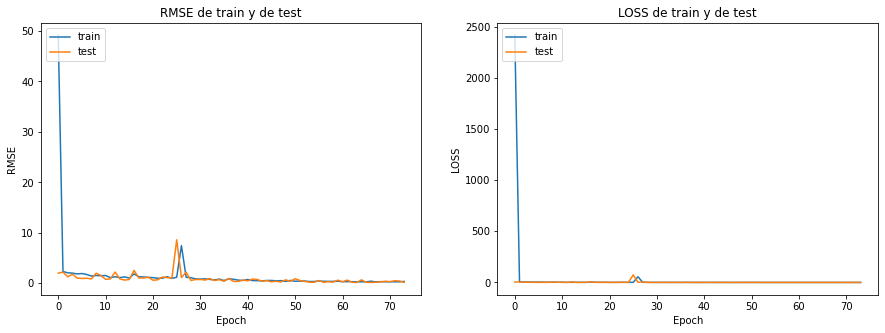

In [80]:
fig, axs = plt.subplots(figsize=[15, 5], ncols=2, nrows=1)

axs[0].plot(history.history['root_mean_squared_error'])
axs[0].plot(history.history['val_root_mean_squared_error'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE de train y de test')
axs[0].legend(['train', 'test'], loc='upper left')


axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('LOSS')
axs[1].set_title('LOSS de train y de test')
axs[1].legend(['train', 'test'], loc='upper left')


plt.show()

# Parte 2: Modelos convolucionales 

Copiamos los datos originales y descartamos la fecha.

In [103]:
dfNN = df_ori.iloc[:,1:].copy(deep=True)

## Tensores

Función para crear los tensores.

In [108]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix > len(sequences)-1:
            break
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, 6] #Variable #6 corresponde a la temperatura
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

Función para estandarizar los datos.

In [87]:
def standarize(df):
    scaler = StandardScaler()
    n0, n1, n2 = df.shape[0], df.shape[1], df.shape[2]
    df = scaler.fit_transform(df.reshape(n0, n1 * n2))
    df = df.reshape(n0, n1, n2)
    return df

Función para particionar los datos en train y test. También realia el shuffle de los datos de entrenamiento. Devuelve los respectivas particiones para train y test. Por otro lado, fijamos el 10% de los datos para test.

In [88]:
def preprocessData(data, n_steps):
    np.random.seed(1234)

    # Generate sequences
    X, y = split_sequences(data.to_numpy(), n_steps)
    
    # % Train / Test
    periodos_test = round(len(X) * 0.1) #10% de los datos para test
    periodos_train = X.shape[0] - periodos_test
    
    #Split train / test
    X_train = X[:periodos_train]
    X_test = X[periodos_train:]
    y_train = y[:periodos_train]
    y_test = y[periodos_train:]
    
    # Shuffle
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    
    return X_train, y_train, X_test, y_test

In [90]:
df.shape

(2193, 8)

Creamos una red convolucional con una arquitectura básica para calcular la cantidad de parámetros a entrenar y la forma del mapa de características de salida después de cada maxpooling (evitando llegar a 0).

In [148]:
model = models.Sequential()
model.add(layers.Conv1D(filters = 32, 
                        kernel_size = 11, 
                        activation='relu', 
                        input_shape=(200, 7),
                        ))  
model.add(layers.MaxPooling1D(pool_size = 2))
model.add(layers.Conv1D(filters = 64, 
                        kernel_size = 11, 
                        activation='relu', 
                        ))  
model.add(layers.MaxPooling1D(pool_size = 2))
model.add(layers.Flatten())
model.add(layers.Dense(units = 1000, activation = 'relu'))
model.add(layers.Dense(units = 1, activation = 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 190, 32)           2496      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 95, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 85, 64)            22592     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 42, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2688)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2689000   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

Consideramos que, en cuanto al hiperparámetro que define el tamaño de la ventana, debemos establecer valores altos si pretendemos agregar más capas a la red (para evitar errores). 

Vamos a buscar el mejor valor para el tamaño del kernel y la cantidad de filtros.

No buscamos el learning rate porque llegábamos a lo que se conoce como desvanecimiento del gradiente (métricas en NaN) incluso usando Adam, por lo tanto, dejamos el optimizador Adam por defecto.

Los filtros los dejamos fijos (32, 64, 128, 256 a medida que crece la red).

Vamos a utilizar la arquitectura básica construida anteriormente.

In [145]:
def buildModelCNN1(epochs, batch_size, hidden_1, kernel_size_1, kernel_size_2, n_steps):
        
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    epochs = int(round(epochs))
    batch_size = int(round(batch_size))
    hidden_1 = int(round(hidden_1))
    kernel_size_1 = int(round(kernel_size_1))
    kernel_size_2 = int(round(kernel_size_2))
    n_steps = int(round(n_steps))
    
    # Serie de tiempo - Split - Shuffle    
    X_train, y_train, X_test, y_test = preprocessData(dfNN, n_steps) # df original
    
    # Standarize
    X_train = standarize(X_train)
    X_test = standarize(X_test)
    
    # build graph
    model = models.Sequential()
    model.add(layers.Conv1D(filters = 32, 
                            kernel_size = kernel_size_1, 
                            activation='relu', 
                            input_shape=(n_steps, len(dfNN.columns)),
                           ))
    
    model.add(layers.MaxPooling1D(pool_size = 2))
    
    model.add(layers.Conv1D(filters = 64, 
                            kernel_size = kernel_size_2, 
                            activation='relu', 
                           ))
    
    model.add(layers.MaxPooling1D(pool_size = 2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(units = hidden_1, activation = 'relu'))
    model.add(layers.Dense(units = 1, activation = 'linear'))
    
    optimizerTf = keras.optimizers.Adam()
    
    model.compile(optimizer = optimizerTf, loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=0.1, verbose = 1)
    y_pred = model.predict(X_test)

    print("Evaluando con epochs ({}), batch_s ({}), hidden_1 ({}),  kernel_size ({}) y una ventana de ({})."
          .format(epochs, batch_size, hidden_1, kernel_size_1, n_steps))
        
    rmse = sqrt(mean_squared_error(y_test, y_pred))    
    print('RMSE {}'.format(rmse))
    return -rmse

#n_steps
#50 valor mínimo (según el summary hecho anteriormente) para evitar errores en el maxxpooling
#200 valor max para evitar problemas con la memoria de la gpu
pbounds = {'epochs': (1, 100), 
           'batch_size' : (1,  len(df_ori)),
           'hidden_1': (2, 500), 
           'kernel_size_1': (1, 11), 
           'kernel_size_2': (1, 11), 
           'n_steps': (50, 200), 
          }

optimizer = BayesianOptimization(
    f = buildModelCNN1,
    pbounds = pbounds,
    random_state = 1,
    verbose = 1
)

In [146]:
%%time 
optimizer.maximize(
    init_points=5,
    n_iter=15,
)

|   iter    |  target   | batch_... |  epochs   | hidden_1  | kernel... | kernel... |  n_steps  |
-------------------------------------------------------------------------------------------------
Train on 1724 samples, validate on 192 samples
Epoch 1/72
1724/1724 [==============================] - 1s 317us/sample - loss: 130.8122 - root_mean_squared_error: 11.4373 - val_loss: 123.0760 - val_root_mean_squared_error: 11.0940
Epoch 2/72
1724/1724 [==============================] - 0s 33us/sample - loss: 114.6584 - root_mean_squared_error: 10.7079 - val_loss: 105.5313 - val_root_mean_squared_error: 10.2728
Epoch 3/72
1724/1724 [==============================] - 0s 33us/sample - loss: 97.5352 - root_mean_squared_error: 9.8760 - val_loss: 87.7762 - val_root_mean_squared_error: 9.3689
Epoch 4/72
1724/1724 [==============================] - 0s 32us/sample - loss: 80.6752 - root_mean_squared_error: 8.9819 - val_loss: 70.5557 - val_root_mean_squared_error: 8.3997
Epoch 5/72
1724/1724 [==========

Epoch 45/72
1724/1724 [==============================] - 0s 30us/sample - loss: 17.4745 - root_mean_squared_error: 4.1802 - val_loss: 17.6922 - val_root_mean_squared_error: 4.2062
Epoch 46/72
1724/1724 [==============================] - 0s 31us/sample - loss: 17.3944 - root_mean_squared_error: 4.1707 - val_loss: 17.6150 - val_root_mean_squared_error: 4.1970
Epoch 47/72
1724/1724 [==============================] - 0s 31us/sample - loss: 17.3251 - root_mean_squared_error: 4.1623 - val_loss: 17.5472 - val_root_mean_squared_error: 4.1889
Epoch 48/72
1724/1724 [==============================] - 0s 31us/sample - loss: 17.2346 - root_mean_squared_error: 4.1515 - val_loss: 17.4948 - val_root_mean_squared_error: 4.1827
Epoch 49/72
1724/1724 [==============================] - 0s 31us/sample - loss: 17.1551 - root_mean_squared_error: 4.1419 - val_loss: 17.4524 - val_root_mean_squared_error: 4.1776
Epoch 50/72
1724/1724 [==============================] - 0s 31us/sample - loss: 17.0730 - root_mean_

Epoch 18/35
1652/1652 [==============================] - 0s 71us/sample - loss: 13.1163 - root_mean_squared_error: 3.6216 - val_loss: 11.8756 - val_root_mean_squared_error: 3.4461
Epoch 19/35
1652/1652 [==============================] - 0s 73us/sample - loss: 12.6748 - root_mean_squared_error: 3.5602 - val_loss: 12.0903 - val_root_mean_squared_error: 3.4771
Epoch 20/35
1652/1652 [==============================] - 0s 69us/sample - loss: 12.3981 - root_mean_squared_error: 3.5211 - val_loss: 11.4519 - val_root_mean_squared_error: 3.3841
Epoch 21/35
1652/1652 [==============================] - 0s 69us/sample - loss: 12.2630 - root_mean_squared_error: 3.5019 - val_loss: 11.0067 - val_root_mean_squared_error: 3.3176
Epoch 22/35
1652/1652 [==============================] - 0s 71us/sample - loss: 11.8491 - root_mean_squared_error: 3.4423 - val_loss: 11.6323 - val_root_mean_squared_error: 3.4106
Epoch 23/35
1652/1652 [==============================] - 0s 71us/sample - loss: 12.1098 - root_mean_

Epoch 27/88
1667/1667 [==============================] - 0s 56us/sample - loss: 15.2056 - root_mean_squared_error: 3.8994 - val_loss: 19.5716 - val_root_mean_squared_error: 4.4240
Epoch 28/88
1667/1667 [==============================] - 0s 54us/sample - loss: 15.0711 - root_mean_squared_error: 3.8821 - val_loss: 19.4049 - val_root_mean_squared_error: 4.4051
Epoch 29/88
1667/1667 [==============================] - 0s 54us/sample - loss: 14.9441 - root_mean_squared_error: 3.8658 - val_loss: 19.3135 - val_root_mean_squared_error: 4.3947
Epoch 30/88
1667/1667 [==============================] - 0s 59us/sample - loss: 14.8117 - root_mean_squared_error: 3.8486 - val_loss: 19.1389 - val_root_mean_squared_error: 4.3748
Epoch 31/88
1667/1667 [==============================] - 0s 57us/sample - loss: 14.6509 - root_mean_squared_error: 3.8277 - val_loss: 19.0344 - val_root_mean_squared_error: 4.3628
Epoch 32/88
1667/1667 [==============================] - 0s 57us/sample - loss: 14.5573 - root_mean_

1667/1667 [==============================] - 0s 56us/sample - loss: 9.7713 - root_mean_squared_error: 3.1259 - val_loss: 13.9023 - val_root_mean_squared_error: 3.7286
Epoch 73/88
1667/1667 [==============================] - 0s 57us/sample - loss: 9.7295 - root_mean_squared_error: 3.1192 - val_loss: 13.8904 - val_root_mean_squared_error: 3.7270
Epoch 74/88
1667/1667 [==============================] - 0s 57us/sample - loss: 9.6356 - root_mean_squared_error: 3.1041 - val_loss: 13.7488 - val_root_mean_squared_error: 3.7079
Epoch 75/88
1667/1667 [==============================] - 0s 58us/sample - loss: 9.4654 - root_mean_squared_error: 3.0766 - val_loss: 13.6682 - val_root_mean_squared_error: 3.6971
Epoch 76/88
1667/1667 [==============================] - 0s 55us/sample - loss: 9.3998 - root_mean_squared_error: 3.0659 - val_loss: 13.5964 - val_root_mean_squared_error: 3.6873
Epoch 77/88
1667/1667 [==============================] - 0s 54us/sample - loss: 9.3199 - root_mean_squared_error: 3.0

Epoch 7/90
1629/1629 [==============================] - 0s 60us/sample - loss: 57.4763 - root_mean_squared_error: 7.5813 - val_loss: 44.7034 - val_root_mean_squared_error: 6.6861
Epoch 8/90
1629/1629 [==============================] - 0s 60us/sample - loss: 57.5666 - root_mean_squared_error: 7.5873 - val_loss: 41.1573 - val_root_mean_squared_error: 6.4154
Epoch 9/90
1629/1629 [==============================] - 0s 59us/sample - loss: 53.4922 - root_mean_squared_error: 7.3138 - val_loss: 35.7357 - val_root_mean_squared_error: 5.9779
Epoch 10/90
1629/1629 [==============================] - 0s 60us/sample - loss: 46.6622 - root_mean_squared_error: 6.8310 - val_loss: 30.4012 - val_root_mean_squared_error: 5.5137
Epoch 11/90
1629/1629 [==============================] - 0s 61us/sample - loss: 39.5645 - root_mean_squared_error: 6.2900 - val_loss: 26.5030 - val_root_mean_squared_error: 5.1481
Epoch 12/90
1629/1629 [==============================] - 0s 59us/sample - loss: 33.9015 - root_mean_squ

Epoch 53/90
1629/1629 [==============================] - 0s 61us/sample - loss: 16.9208 - root_mean_squared_error: 4.1135 - val_loss: 13.9830 - val_root_mean_squared_error: 3.7394
Epoch 54/90
1629/1629 [==============================] - 0s 60us/sample - loss: 16.8241 - root_mean_squared_error: 4.1017 - val_loss: 13.8629 - val_root_mean_squared_error: 3.7233
Epoch 55/90
1629/1629 [==============================] - 0s 60us/sample - loss: 16.7353 - root_mean_squared_error: 4.0909 - val_loss: 13.7766 - val_root_mean_squared_error: 3.7117
Epoch 56/90
1629/1629 [==============================] - 0s 60us/sample - loss: 16.6652 - root_mean_squared_error: 4.0823 - val_loss: 13.7267 - val_root_mean_squared_error: 3.7050
Epoch 57/90
1629/1629 [==============================] - 0s 59us/sample - loss: 16.6094 - root_mean_squared_error: 4.0755 - val_loss: 13.7021 - val_root_mean_squared_error: 3.7016
Epoch 58/90
1629/1629 [==============================] - 0s 60us/sample - loss: 16.5536 - root_mean_

Epoch 8/95
1625/1625 [==============================] - 0s 61us/sample - loss: 52.8134 - root_mean_squared_error: 7.2673 - val_loss: 39.3875 - val_root_mean_squared_error: 6.2759
Epoch 9/95
1625/1625 [==============================] - 0s 61us/sample - loss: 46.2427 - root_mean_squared_error: 6.8002 - val_loss: 32.2692 - val_root_mean_squared_error: 5.6806
Epoch 10/95
1625/1625 [==============================] - 0s 62us/sample - loss: 37.9757 - root_mean_squared_error: 6.1624 - val_loss: 26.7184 - val_root_mean_squared_error: 5.1690
Epoch 11/95
1625/1625 [==============================] - 0s 61us/sample - loss: 31.1710 - root_mean_squared_error: 5.5831 - val_loss: 23.6543 - val_root_mean_squared_error: 4.8636
Epoch 12/95
1625/1625 [==============================] - 0s 61us/sample - loss: 26.9594 - root_mean_squared_error: 5.1922 - val_loss: 22.4424 - val_root_mean_squared_error: 4.7373
Epoch 13/95
1625/1625 [==============================] - 0s 61us/sample - loss: 24.8355 - root_mean_sq

Epoch 54/95
1625/1625 [==============================] - 0s 63us/sample - loss: 16.2092 - root_mean_squared_error: 4.0261 - val_loss: 14.3735 - val_root_mean_squared_error: 3.7912
Epoch 55/95
1625/1625 [==============================] - 0s 62us/sample - loss: 16.1092 - root_mean_squared_error: 4.0136 - val_loss: 14.3643 - val_root_mean_squared_error: 3.7900
Epoch 56/95
1625/1625 [==============================] - 0s 61us/sample - loss: 16.0285 - root_mean_squared_error: 4.0036 - val_loss: 14.3827 - val_root_mean_squared_error: 3.7925
Epoch 57/95
1625/1625 [==============================] - 0s 61us/sample - loss: 15.9791 - root_mean_squared_error: 3.9974 - val_loss: 14.4098 - val_root_mean_squared_error: 3.7960
Epoch 58/95
1625/1625 [==============================] - 0s 62us/sample - loss: 15.9489 - root_mean_squared_error: 3.9936 - val_loss: 14.4161 - val_root_mean_squared_error: 3.7969
Epoch 59/95
1625/1625 [==============================] - 0s 61us/sample - loss: 15.9147 - root_mean_

1647/1647 [==============================] - 0s 73us/sample - loss: 32.3687 - root_mean_squared_error: 5.6893 - val_loss: 22.4484 - val_root_mean_squared_error: 4.7380
Epoch 4/6
1647/1647 [==============================] - 0s 73us/sample - loss: 22.3851 - root_mean_squared_error: 4.7313 - val_loss: 19.8938 - val_root_mean_squared_error: 4.4602
Epoch 5/6
1647/1647 [==============================] - 0s 72us/sample - loss: 19.6156 - root_mean_squared_error: 4.4289 - val_loss: 20.6723 - val_root_mean_squared_error: 4.5467
Epoch 6/6
1647/1647 [==============================] - 0s 71us/sample - loss: 20.8130 - root_mean_squared_error: 4.5621 - val_loss: 18.0698 - val_root_mean_squared_error: 4.2509
Evaluando con epochs (6), batch_s (482), hidden_1 (227),  kernel_size (9) y una ventana de (160).
RMSE 5.476794521208075
Train on 1654 samples, validate on 184 samples
Epoch 1/48
1654/1654 [==============================] - 1s 684us/sample - loss: 86.9369 - root_mean_squared_error: 9.3240 - val_lo

Epoch 42/48
1654/1654 [==============================] - 0s 68us/sample - loss: 5.3217 - root_mean_squared_error: 2.3069 - val_loss: 7.7731 - val_root_mean_squared_error: 2.7880
Epoch 43/48
1654/1654 [==============================] - 0s 68us/sample - loss: 5.1742 - root_mean_squared_error: 2.2747 - val_loss: 7.7032 - val_root_mean_squared_error: 2.7755
Epoch 44/48
1654/1654 [==============================] - 0s 69us/sample - loss: 5.2567 - root_mean_squared_error: 2.2927 - val_loss: 7.5953 - val_root_mean_squared_error: 2.7560
Epoch 45/48
1654/1654 [==============================] - 0s 68us/sample - loss: 4.9782 - root_mean_squared_error: 2.2312 - val_loss: 7.5568 - val_root_mean_squared_error: 2.7490
Epoch 46/48
1654/1654 [==============================] - 0s 67us/sample - loss: 4.8108 - root_mean_squared_error: 2.1933 - val_loss: 7.4597 - val_root_mean_squared_error: 2.7312
Epoch 47/48
1654/1654 [==============================] - 0s 66us/sample - loss: 4.5648 - root_mean_squared_err

Epoch 39/98
1686/1686 [==============================] - 0s 63us/sample - loss: 7.8244 - root_mean_squared_error: 2.7972 - val_loss: 9.9219 - val_root_mean_squared_error: 3.1499
Epoch 40/98
1686/1686 [==============================] - 0s 64us/sample - loss: 7.8787 - root_mean_squared_error: 2.8069 - val_loss: 10.3628 - val_root_mean_squared_error: 3.2191
Epoch 41/98
1686/1686 [==============================] - 0s 64us/sample - loss: 7.4964 - root_mean_squared_error: 2.7379 - val_loss: 10.0445 - val_root_mean_squared_error: 3.1693
Epoch 42/98
1686/1686 [==============================] - 0s 63us/sample - loss: 7.1055 - root_mean_squared_error: 2.6656 - val_loss: 9.4356 - val_root_mean_squared_error: 3.0717
Epoch 43/98
1686/1686 [==============================] - 0s 64us/sample - loss: 7.1055 - root_mean_squared_error: 2.6656 - val_loss: 9.0414 - val_root_mean_squared_error: 3.0069
Epoch 44/98
1686/1686 [==============================] - 0s 63us/sample - loss: 6.3222 - root_mean_squared_e

1686/1686 [==============================] - 0s 66us/sample - loss: 1.7061 - root_mean_squared_error: 1.3062 - val_loss: 6.9503 - val_root_mean_squared_error: 2.6363
Epoch 86/98
1686/1686 [==============================] - 0s 64us/sample - loss: 1.5996 - root_mean_squared_error: 1.2647 - val_loss: 7.0580 - val_root_mean_squared_error: 2.6567
Epoch 87/98
1686/1686 [==============================] - 0s 64us/sample - loss: 1.5764 - root_mean_squared_error: 1.2555 - val_loss: 6.8857 - val_root_mean_squared_error: 2.6241
Epoch 88/98
1686/1686 [==============================] - 0s 64us/sample - loss: 1.5013 - root_mean_squared_error: 1.2253 - val_loss: 6.9197 - val_root_mean_squared_error: 2.6305
Epoch 89/98
1686/1686 [==============================] - 0s 64us/sample - loss: 1.4135 - root_mean_squared_error: 1.1889 - val_loss: 6.9492 - val_root_mean_squared_error: 2.6361
Epoch 90/98
1686/1686 [==============================] - 0s 65us/sample - loss: 1.3783 - root_mean_squared_error: 1.1740 -

Epoch 15/58
1731/1731 [==============================] - 0s 34us/sample - loss: 20.6545 - root_mean_squared_error: 4.5447 - val_loss: 20.8784 - val_root_mean_squared_error: 4.5693
Epoch 16/58
1731/1731 [==============================] - 0s 34us/sample - loss: 20.5049 - root_mean_squared_error: 4.5282 - val_loss: 21.5406 - val_root_mean_squared_error: 4.6412
Epoch 17/58
1731/1731 [==============================] - 0s 35us/sample - loss: 21.0070 - root_mean_squared_error: 4.5833 - val_loss: 21.0645 - val_root_mean_squared_error: 4.5896
Epoch 18/58
1731/1731 [==============================] - 0s 34us/sample - loss: 20.7915 - root_mean_squared_error: 4.5598 - val_loss: 20.0802 - val_root_mean_squared_error: 4.4811
Epoch 19/58
1731/1731 [==============================] - 0s 34us/sample - loss: 20.3353 - root_mean_squared_error: 4.5095 - val_loss: 19.5251 - val_root_mean_squared_error: 4.4187
Epoch 20/58
1731/1731 [==============================] - 0s 34us/sample - loss: 20.2103 - root_mean_

1656/1656 [==============================] - 1s 758us/sample - loss: 94.7545 - root_mean_squared_error: 9.7342 - val_loss: 50.0312 - val_root_mean_squared_error: 7.0733
Epoch 2/37
1656/1656 [==============================] - 0s 74us/sample - loss: 40.9231 - root_mean_squared_error: 6.3971 - val_loss: 31.8728 - val_root_mean_squared_error: 5.6456
Epoch 3/37
1656/1656 [==============================] - 0s 73us/sample - loss: 26.2790 - root_mean_squared_error: 5.1263 - val_loss: 24.9620 - val_root_mean_squared_error: 4.9962
Epoch 4/37
1656/1656 [==============================] - 0s 74us/sample - loss: 22.8680 - root_mean_squared_error: 4.7820 - val_loss: 21.9825 - val_root_mean_squared_error: 4.6886
Epoch 5/37
1656/1656 [==============================] - 0s 76us/sample - loss: 23.4724 - root_mean_squared_error: 4.8448 - val_loss: 18.6165 - val_root_mean_squared_error: 4.3147
Epoch 6/37
1656/1656 [==============================] - 0s 76us/sample - loss: 19.5728 - root_mean_squared_error: 4

Epoch 9/100
1632/1632 [==============================] - 0s 64us/sample - loss: 50.2348 - root_mean_squared_error: 7.0877 - val_loss: 29.8720 - val_root_mean_squared_error: 5.4655
Epoch 10/100
1632/1632 [==============================] - 0s 64us/sample - loss: 40.7940 - root_mean_squared_error: 6.3870 - val_loss: 25.0966 - val_root_mean_squared_error: 5.0097
Epoch 11/100
1632/1632 [==============================] - 0s 64us/sample - loss: 34.7647 - root_mean_squared_error: 5.8962 - val_loss: 23.6216 - val_root_mean_squared_error: 4.8602
Epoch 12/100
1632/1632 [==============================] - 0s 64us/sample - loss: 32.2217 - root_mean_squared_error: 5.6764 - val_loss: 23.5271 - val_root_mean_squared_error: 4.8505
Epoch 13/100
1632/1632 [==============================] - 0s 64us/sample - loss: 31.2704 - root_mean_squared_error: 5.5920 - val_loss: 23.1310 - val_root_mean_squared_error: 4.8095
Epoch 14/100
1632/1632 [==============================] - 0s 65us/sample - loss: 30.2175 - root_

Epoch 55/100
1632/1632 [==============================] - 0s 65us/sample - loss: 16.3361 - root_mean_squared_error: 4.0418 - val_loss: 13.5282 - val_root_mean_squared_error: 3.6781
Epoch 56/100
1632/1632 [==============================] - 0s 64us/sample - loss: 16.3326 - root_mean_squared_error: 4.0414 - val_loss: 13.5352 - val_root_mean_squared_error: 3.6790
Epoch 57/100
1632/1632 [==============================] - 0s 65us/sample - loss: 16.3107 - root_mean_squared_error: 4.0387 - val_loss: 13.5314 - val_root_mean_squared_error: 3.6785
Epoch 58/100
1632/1632 [==============================] - 0s 65us/sample - loss: 16.2473 - root_mean_squared_error: 4.0308 - val_loss: 13.5285 - val_root_mean_squared_error: 3.6781
Epoch 59/100
1632/1632 [==============================] - 0s 65us/sample - loss: 16.1582 - root_mean_squared_error: 4.0197 - val_loss: 13.5459 - val_root_mean_squared_error: 3.6805
Epoch 60/100
1632/1632 [==============================] - 0s 65us/sample - loss: 16.0753 - root

Evaluando con epochs (100), batch_s (1923), hidden_1 (45),  kernel_size (6) y una ventana de (177).
RMSE 5.099955251586134
Train on 1664 samples, validate on 185 samples
Epoch 1/33
1664/1664 [==============================] - 1s 605us/sample - loss: 94.8764 - root_mean_squared_error: 9.7405 - val_loss: 57.9536 - val_root_mean_squared_error: 7.6127
Epoch 2/33
1664/1664 [==============================] - 0s 67us/sample - loss: 47.7092 - root_mean_squared_error: 6.9072 - val_loss: 38.7107 - val_root_mean_squared_error: 6.2218
Epoch 3/33
1664/1664 [==============================] - 0s 67us/sample - loss: 33.0455 - root_mean_squared_error: 5.7485 - val_loss: 27.6082 - val_root_mean_squared_error: 5.2544
Epoch 4/33
1664/1664 [==============================] - 0s 67us/sample - loss: 22.9226 - root_mean_squared_error: 4.7878 - val_loss: 21.0600 - val_root_mean_squared_error: 4.5891
Epoch 5/33
1664/1664 [==============================] - 0s 67us/sample - loss: 19.4722 - root_mean_squared_error:

Epoch 12/72
1732/1732 [==============================] - 0s 32us/sample - loss: 25.4555 - root_mean_squared_error: 5.0453 - val_loss: 23.3913 - val_root_mean_squared_error: 4.8365
Epoch 13/72
1732/1732 [==============================] - 0s 31us/sample - loss: 22.9314 - root_mean_squared_error: 4.7887 - val_loss: 20.0499 - val_root_mean_squared_error: 4.4777
Epoch 14/72
1732/1732 [==============================] - 0s 31us/sample - loss: 20.6683 - root_mean_squared_error: 4.5462 - val_loss: 18.5856 - val_root_mean_squared_error: 4.3111
Epoch 15/72
1732/1732 [==============================] - 0s 32us/sample - loss: 20.3501 - root_mean_squared_error: 4.5111 - val_loss: 18.5209 - val_root_mean_squared_error: 4.3036
Epoch 16/72
1732/1732 [==============================] - 0s 32us/sample - loss: 21.0705 - root_mean_squared_error: 4.5903 - val_loss: 17.9199 - val_root_mean_squared_error: 4.2332
Epoch 17/72
1732/1732 [==============================] - 0s 32us/sample - loss: 20.4332 - root_mean_

1732/1732 [==============================] - 0s 33us/sample - loss: 13.1401 - root_mean_squared_error: 3.6249 - val_loss: 12.6695 - val_root_mean_squared_error: 3.5594
Epoch 58/72
1732/1732 [==============================] - 0s 33us/sample - loss: 13.0160 - root_mean_squared_error: 3.6078 - val_loss: 12.6412 - val_root_mean_squared_error: 3.5554
Epoch 59/72
1732/1732 [==============================] - 0s 32us/sample - loss: 12.8610 - root_mean_squared_error: 3.5862 - val_loss: 12.6892 - val_root_mean_squared_error: 3.5622
Epoch 60/72
1732/1732 [==============================] - 0s 32us/sample - loss: 12.8052 - root_mean_squared_error: 3.5784 - val_loss: 12.4329 - val_root_mean_squared_error: 3.5260
Epoch 61/72
1732/1732 [==============================] - 0s 32us/sample - loss: 12.5722 - root_mean_squared_error: 3.5457 - val_loss: 12.1834 - val_root_mean_squared_error: 3.4905
Epoch 62/72
1732/1732 [==============================] - 0s 31us/sample - loss: 12.4183 - root_mean_squared_erro

Epoch 29/36
1652/1652 [==============================] - 0s 80us/sample - loss: 11.2459 - root_mean_squared_error: 3.3535 - val_loss: 10.1790 - val_root_mean_squared_error: 3.1905
Epoch 30/36
1652/1652 [==============================] - 0s 80us/sample - loss: 11.1839 - root_mean_squared_error: 3.3442 - val_loss: 10.6492 - val_root_mean_squared_error: 3.2633
Epoch 31/36
1652/1652 [==============================] - 0s 79us/sample - loss: 11.0224 - root_mean_squared_error: 3.3200 - val_loss: 10.2081 - val_root_mean_squared_error: 3.1950
Epoch 32/36
1652/1652 [==============================] - 0s 80us/sample - loss: 10.4511 - root_mean_squared_error: 3.2328 - val_loss: 10.4028 - val_root_mean_squared_error: 3.2253
Epoch 33/36
1652/1652 [==============================] - 0s 80us/sample - loss: 10.4308 - root_mean_squared_error: 3.2297 - val_loss: 10.9306 - val_root_mean_squared_error: 3.3061
Epoch 34/36
1652/1652 [==============================] - 0s 80us/sample - loss: 10.8255 - root_mean_

Epoch 16/73
1722/1722 [==============================] - 0s 38us/sample - loss: 19.4667 - root_mean_squared_error: 4.4121 - val_loss: 21.3839 - val_root_mean_squared_error: 4.6243
Epoch 17/73
1722/1722 [==============================] - 0s 38us/sample - loss: 19.4308 - root_mean_squared_error: 4.4080 - val_loss: 21.2971 - val_root_mean_squared_error: 4.6149
Epoch 18/73
1722/1722 [==============================] - 0s 38us/sample - loss: 19.4237 - root_mean_squared_error: 4.4072 - val_loss: 21.1605 - val_root_mean_squared_error: 4.6001
Epoch 19/73
1722/1722 [==============================] - 0s 37us/sample - loss: 19.1125 - root_mean_squared_error: 4.3718 - val_loss: 20.7981 - val_root_mean_squared_error: 4.5605
Epoch 20/73
1722/1722 [==============================] - 0s 38us/sample - loss: 18.4079 - root_mean_squared_error: 4.2904 - val_loss: 20.8200 - val_root_mean_squared_error: 4.5629
Epoch 21/73
1722/1722 [==============================] - 0s 38us/sample - loss: 18.0978 - root_mean_

1722/1722 [==============================] - 0s 39us/sample - loss: 11.8709 - root_mean_squared_error: 3.4454 - val_loss: 15.4527 - val_root_mean_squared_error: 3.9310
Epoch 62/73
1722/1722 [==============================] - 0s 39us/sample - loss: 11.4199 - root_mean_squared_error: 3.3793 - val_loss: 15.1946 - val_root_mean_squared_error: 3.8980
Epoch 63/73
1722/1722 [==============================] - 0s 39us/sample - loss: 11.2506 - root_mean_squared_error: 3.3542 - val_loss: 14.9989 - val_root_mean_squared_error: 3.8728
Epoch 64/73
1722/1722 [==============================] - 0s 39us/sample - loss: 11.1098 - root_mean_squared_error: 3.3331 - val_loss: 14.8285 - val_root_mean_squared_error: 3.8508
Epoch 65/73
1722/1722 [==============================] - 0s 39us/sample - loss: 11.0045 - root_mean_squared_error: 3.3173 - val_loss: 14.6664 - val_root_mean_squared_error: 3.8297
Epoch 66/73
1722/1722 [==============================] - 0s 37us/sample - loss: 10.8587 - root_mean_squared_erro

1687/1687 [==============================] - 0s 164us/sample - loss: 0.7411 - root_mean_squared_error: 0.8608 - val_loss: 6.6962 - val_root_mean_squared_error: 2.5877
Epoch 33/34
1687/1687 [==============================] - 0s 165us/sample - loss: 0.6941 - root_mean_squared_error: 0.8331 - val_loss: 6.2744 - val_root_mean_squared_error: 2.5049
Epoch 34/34
1687/1687 [==============================] - 0s 161us/sample - loss: 0.4269 - root_mean_squared_error: 0.6534 - val_loss: 6.0360 - val_root_mean_squared_error: 2.4568
Evaluando con epochs (34), batch_s (39), hidden_1 (234),  kernel_size (4) y una ventana de (110).
RMSE 5.895987317309207
Train on 1731 samples, validate on 193 samples
Epoch 1/76
1731/1731 [==============================] - 1s 581us/sample - loss: 161.5024 - root_mean_squared_error: 12.7084 - val_loss: 127.9944 - val_root_mean_squared_error: 11.3135
Epoch 2/76
1731/1731 [==============================] - 0s 33us/sample - loss: 118.9000 - root_mean_squared_error: 10.9041 

Epoch 43/76
1731/1731 [==============================] - 0s 35us/sample - loss: 16.3694 - root_mean_squared_error: 4.0459 - val_loss: 16.2633 - val_root_mean_squared_error: 4.0328
Epoch 44/76
1731/1731 [==============================] - 0s 35us/sample - loss: 16.2350 - root_mean_squared_error: 4.0293 - val_loss: 16.0756 - val_root_mean_squared_error: 4.0094
Epoch 45/76
1731/1731 [==============================] - 0s 34us/sample - loss: 16.1313 - root_mean_squared_error: 4.0164 - val_loss: 15.9597 - val_root_mean_squared_error: 3.9950
Epoch 46/76
1731/1731 [==============================] - 0s 35us/sample - loss: 16.0342 - root_mean_squared_error: 4.0043 - val_loss: 15.8644 - val_root_mean_squared_error: 3.9830
Epoch 47/76
1731/1731 [==============================] - 0s 35us/sample - loss: 15.8936 - root_mean_squared_error: 3.9867 - val_loss: 15.8673 - val_root_mean_squared_error: 3.9834
Epoch 48/76
1731/1731 [==============================] - 0s 34us/sample - loss: 15.7221 - root_mean_

In [147]:
optimizer.max

{'target': -4.798367922868679,
 'params': {'batch_size': 1524.7285471043224,
  'epochs': 72.28449711295119,
  'hidden_1': 162.13899648661223,
  'kernel_size_1': 6.583312795883248,
  'kernel_size_2': 3.1490562671117877,
  'n_steps': 54.47231786367105}}

El RMSE obtenido (4.79) es muy alto en comparación con el del mejor modelo shallow (0.15). Procedemos a aumentar el tamaño de la red y añadir un dropout entre las capas densas para luego analizar su comportamiento.

In [164]:
model = models.Sequential()
model.add(layers.Conv1D(filters = 32, 
                        kernel_size = 11, 
                        activation='relu', 
                        input_shape=(200, 7),
                        ))  
model.add(layers.MaxPooling1D(pool_size = 2))

model.add(layers.Conv1D(filters = 64, 
                        kernel_size = 11, 
                        activation='relu', 
                        ))  
model.add(layers.MaxPooling1D(pool_size = 2))

model.add(layers.Conv1D(filters = 128, 
                        kernel_size = 11, 
                        activation='relu', 
                        ))  
model.add(layers.MaxPooling1D(pool_size = 2))

model.add(layers.Flatten())
model.add(layers.Dense(units = 500, activation = 'relu'))
model.add(layers.Dense(units = 500, activation = 'relu'))
model.add(layers.Dense(units = 1, activation = 'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 190, 32)           2496      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 95, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 85, 64)            22592     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 42, 64)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 32, 128)           90240     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 16, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

In [167]:
def buildModelCNN2(epochs, batch_size, hidden_1, hidden_2, kernel_size_1, kernel_size_2, kernel_size_3, n_steps, dropout_1):
        
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    epochs = int(round(epochs))
    batch_size = int(round(batch_size))
    hidden_1 = int(round(hidden_1))
    hidden_2 = int(round(hidden_2))
    kernel_size_1 = int(round(kernel_size_1))
    kernel_size_2 = int(round(kernel_size_2))
    kernel_size_3 = int(round(kernel_size_3))
    n_steps = int(round(n_steps))
    
    # Serie de tiempo - Split - Shuffle    
    X_train, y_train, X_test, y_test = preprocessData(dfNN, n_steps) # df original
    
    # Standarize
    X_train = standarize(X_train)
    X_test = standarize(X_test)
    
    # build graph
    model = models.Sequential()
    
    model.add(layers.Conv1D(filters = 32, 
                            kernel_size = kernel_size_1, 
                            activation='relu', 
                            input_shape=(n_steps, len(dfNN.columns)),
                           ))
    model.add(layers.MaxPooling1D(pool_size = 2))
    
    
    model.add(layers.Conv1D(filters = 64, 
                            kernel_size = kernel_size_2, 
                            activation='relu', 
                           ))
    model.add(layers.MaxPooling1D(pool_size = 2))
    
    
    model.add(layers.Conv1D(filters = 128, 
                            kernel_size = kernel_size_3, 
                            activation='relu', 
                           ))  
    model.add(layers.MaxPooling1D(pool_size = 2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(units = hidden_1, activation = 'relu'))
    model.add(layers.Dropout(dropout_1))
    model.add(layers.Dense(units = hidden_1, activation = 'relu'))
    model.add(layers.Dense(units = 1, activation = 'linear'))
    
    optimizerTf = keras.optimizers.Adam()
    
    model.compile(optimizer = optimizerTf, loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=0.1, verbose = 1)
    y_pred = model.predict(X_test)

    print("Evaluando con epochs ({}), batch_s ({}), hidden_1 ({}),  kernel_size_1 ({}), kernel_size_2 ({}) , kernel_size_2 ({})  y una ventana de ({})."
          .format(epochs, batch_size, hidden_1, kernel_size_1, kernel_size_2, kernel_size_3, n_steps))
        
    rmse = sqrt(mean_squared_error(y_test, y_pred))    
    print('RMSE {}'.format(rmse))
    return -rmse

#Aumentamos el tamaño mínimo de la ventana debido a errores de dimensión de los tensores.
pbounds = {'epochs': (1, 100), 
           'batch_size' : (1,  len(df_ori)),
           'hidden_1': (2, 500), 
           'hidden_2': (2, 500), 
           'kernel_size_1': (1, 11), 
           'kernel_size_2': (1, 11), 
           'kernel_size_3': (1, 11), 
           'n_steps': (80, 200), 
           'dropout_1': (0, 0.5)
          }

optimizer = BayesianOptimization(
    f = buildModelCNN2,
    pbounds = pbounds,
    random_state = 1,
    verbose = 1
)

In [168]:
%%time 
optimizer.maximize(
    init_points=3,
    n_iter=10,
)

|   iter    |  target   | batch_... | dropout_1 |  epochs   | hidden_1  | hidden_2  | kernel... | kernel... | kernel... |  n_steps  |
-------------------------------------------------------------------------------------------------------------------------------------
Train on 1673 samples, validate on 186 samples
1673/1673 [==============================] - 2s 1ms/sample - loss: 138.8403 - root_mean_squared_error: 11.7830 - val_loss: 112.1384 - val_root_mean_squared_error: 10.5895
Evaluando con epochs (1), batch_s (915), hidden_1 (153),  kernel_size_1 (2), kernel_size_2 (3) , kernel_size_2 (4)  y una ventana de (128).
RMSE 12.474242682689313
Train on 1656 samples, validate on 185 samples
Epoch 1/69
1656/1656 [==============================] - 1s 837us/sample - loss: 142.3468 - root_mean_squared_error: 11.9309 - val_loss: 116.7559 - val_root_mean_squared_error: 10.8054
Epoch 2/69
1656/1656 [==============================] - 0s 87us/sample - loss: 100.4502 - root_mean_squared_error: 10.0

Epoch 43/69
1656/1656 [==============================] - 0s 86us/sample - loss: 15.4810 - root_mean_squared_error: 3.9346 - val_loss: 13.6592 - val_root_mean_squared_error: 3.6958
Epoch 44/69
1656/1656 [==============================] - 0s 87us/sample - loss: 15.1486 - root_mean_squared_error: 3.8921 - val_loss: 13.8527 - val_root_mean_squared_error: 3.7219
Epoch 45/69
1656/1656 [==============================] - 0s 87us/sample - loss: 14.9952 - root_mean_squared_error: 3.8724 - val_loss: 14.4582 - val_root_mean_squared_error: 3.8024
Epoch 46/69
1656/1656 [==============================] - 0s 86us/sample - loss: 14.6928 - root_mean_squared_error: 3.8331 - val_loss: 13.2210 - val_root_mean_squared_error: 3.6361
Epoch 47/69
1656/1656 [==============================] - 0s 86us/sample - loss: 15.0512 - root_mean_squared_error: 3.8796 - val_loss: 14.4673 - val_root_mean_squared_error: 3.8036
Epoch 48/69
1656/1656 [==============================] - 0s 87us/sample - loss: 15.0012 - root_mean_

Epoch 17/80
1703/1703 [==============================] - 0s 76us/sample - loss: 10.2832 - root_mean_squared_error: 3.2067 - val_loss: 13.2981 - val_root_mean_squared_error: 3.6467
Epoch 18/80
1703/1703 [==============================] - 0s 77us/sample - loss: 9.1668 - root_mean_squared_error: 3.0277 - val_loss: 12.1767 - val_root_mean_squared_error: 3.4895
Epoch 19/80
1703/1703 [==============================] - 0s 76us/sample - loss: 8.1923 - root_mean_squared_error: 2.8622 - val_loss: 11.9316 - val_root_mean_squared_error: 3.4542
Epoch 20/80
1703/1703 [==============================] - 0s 76us/sample - loss: 7.0489 - root_mean_squared_error: 2.6550 - val_loss: 11.5458 - val_root_mean_squared_error: 3.3979
Epoch 21/80
1703/1703 [==============================] - 0s 78us/sample - loss: 6.3257 - root_mean_squared_error: 2.5151 - val_loss: 10.3293 - val_root_mean_squared_error: 3.2139
Epoch 22/80
1703/1703 [==============================] - 0s 78us/sample - loss: 5.8150 - root_mean_squar

Epoch 63/80
1703/1703 [==============================] - 0s 76us/sample - loss: 0.3915 - root_mean_squared_error: 0.6257 - val_loss: 7.5346 - val_root_mean_squared_error: 2.7449
Epoch 64/80
1703/1703 [==============================] - 0s 77us/sample - loss: 0.4598 - root_mean_squared_error: 0.6781 - val_loss: 7.3901 - val_root_mean_squared_error: 2.7185
Epoch 65/80
1703/1703 [==============================] - 0s 78us/sample - loss: 0.4699 - root_mean_squared_error: 0.6855 - val_loss: 7.8841 - val_root_mean_squared_error: 2.8079
Epoch 66/80
1703/1703 [==============================] - 0s 78us/sample - loss: 0.5685 - root_mean_squared_error: 0.7540 - val_loss: 7.5911 - val_root_mean_squared_error: 2.7552
Epoch 67/80
1703/1703 [==============================] - 0s 77us/sample - loss: 0.4979 - root_mean_squared_error: 0.7056 - val_loss: 8.1363 - val_root_mean_squared_error: 2.8524
Epoch 68/80
1703/1703 [==============================] - 0s 77us/sample - loss: 0.4922 - root_mean_squared_err

Epoch 27/39
1646/1646 [==============================] - 0s 96us/sample - loss: 19.6145 - root_mean_squared_error: 4.4288 - val_loss: 21.5131 - val_root_mean_squared_error: 4.6382
Epoch 28/39
1646/1646 [==============================] - 0s 96us/sample - loss: 19.0909 - root_mean_squared_error: 4.3693 - val_loss: 22.1170 - val_root_mean_squared_error: 4.7029
Epoch 29/39
1646/1646 [==============================] - 0s 95us/sample - loss: 19.4118 - root_mean_squared_error: 4.4059 - val_loss: 22.7843 - val_root_mean_squared_error: 4.7733
Epoch 30/39
1646/1646 [==============================] - 0s 97us/sample - loss: 20.1540 - root_mean_squared_error: 4.4893 - val_loss: 22.6113 - val_root_mean_squared_error: 4.7551
Epoch 31/39
1646/1646 [==============================] - 0s 96us/sample - loss: 19.8904 - root_mean_squared_error: 4.4599 - val_loss: 21.6955 - val_root_mean_squared_error: 4.6578
Epoch 32/39
1646/1646 [==============================] - 0s 96us/sample - loss: 18.7908 - root_mean_

Epoch 12/25
1645/1645 [==============================] - 0s 98us/sample - loss: 25.7317 - root_mean_squared_error: 5.0726 - val_loss: 35.6940 - val_root_mean_squared_error: 5.9744
Epoch 13/25
1645/1645 [==============================] - 0s 93us/sample - loss: 30.5194 - root_mean_squared_error: 5.5244 - val_loss: 39.0647 - val_root_mean_squared_error: 6.2502
Epoch 14/25
1645/1645 [==============================] - 0s 92us/sample - loss: 33.4133 - root_mean_squared_error: 5.7804 - val_loss: 30.5473 - val_root_mean_squared_error: 5.5270
Epoch 15/25
1645/1645 [==============================] - 0s 93us/sample - loss: 26.3040 - root_mean_squared_error: 5.1287 - val_loss: 22.3686 - val_root_mean_squared_error: 4.7295
Epoch 16/25
1645/1645 [==============================] - 0s 93us/sample - loss: 19.9218 - root_mean_squared_error: 4.4634 - val_loss: 21.0011 - val_root_mean_squared_error: 4.5827
Epoch 17/25
1645/1645 [==============================] - 0s 93us/sample - loss: 19.9623 - root_mean_

Epoch 31/35
1622/1622 [==============================] - 0s 116us/sample - loss: 13.7932 - root_mean_squared_error: 3.7139 - val_loss: 14.6527 - val_root_mean_squared_error: 3.8279
Epoch 32/35
1622/1622 [==============================] - 0s 116us/sample - loss: 13.9765 - root_mean_squared_error: 3.7385 - val_loss: 15.6416 - val_root_mean_squared_error: 3.9549
Epoch 33/35
1622/1622 [==============================] - 0s 115us/sample - loss: 13.4072 - root_mean_squared_error: 3.6616 - val_loss: 14.4164 - val_root_mean_squared_error: 3.7969
Epoch 34/35
1622/1622 [==============================] - 0s 116us/sample - loss: 13.4040 - root_mean_squared_error: 3.6611 - val_loss: 14.6142 - val_root_mean_squared_error: 3.8229
Epoch 35/35
1622/1622 [==============================] - 0s 118us/sample - loss: 13.0966 - root_mean_squared_error: 3.6189 - val_loss: 15.5387 - val_root_mean_squared_error: 3.9419
Evaluando con epochs (35), batch_s (1103), hidden_1 (344),  kernel_size_1 (6), kernel_size_2 (1

1704/1704 [==============================] - 0s 90us/sample - loss: 0.9155 - root_mean_squared_error: 0.9568 - val_loss: 8.3970 - val_root_mean_squared_error: 2.8978
Epoch 41/90
1704/1704 [==============================] - 0s 89us/sample - loss: 0.8580 - root_mean_squared_error: 0.9263 - val_loss: 8.6081 - val_root_mean_squared_error: 2.9340
Epoch 42/90
1704/1704 [==============================] - 0s 89us/sample - loss: 1.0146 - root_mean_squared_error: 1.0073 - val_loss: 8.6175 - val_root_mean_squared_error: 2.9356
Epoch 43/90
1704/1704 [==============================] - 0s 88us/sample - loss: 0.7571 - root_mean_squared_error: 0.8701 - val_loss: 8.3023 - val_root_mean_squared_error: 2.8814
Epoch 44/90
1704/1704 [==============================] - 0s 88us/sample - loss: 0.6818 - root_mean_squared_error: 0.8257 - val_loss: 8.4837 - val_root_mean_squared_error: 2.9127
Epoch 45/90
1704/1704 [==============================] - 0s 85us/sample - loss: 0.6807 - root_mean_squared_error: 0.8250 -

1704/1704 [==============================] - 0s 86us/sample - loss: 0.2239 - root_mean_squared_error: 0.4731 - val_loss: 7.5953 - val_root_mean_squared_error: 2.7560
Epoch 87/90
1704/1704 [==============================] - 0s 86us/sample - loss: 0.2226 - root_mean_squared_error: 0.4718 - val_loss: 7.5327 - val_root_mean_squared_error: 2.7446
Epoch 88/90
1704/1704 [==============================] - 0s 86us/sample - loss: 0.2960 - root_mean_squared_error: 0.5441 - val_loss: 7.9805 - val_root_mean_squared_error: 2.8250
Epoch 89/90
1704/1704 [==============================] - 0s 88us/sample - loss: 0.3826 - root_mean_squared_error: 0.6185 - val_loss: 7.9858 - val_root_mean_squared_error: 2.8259
Epoch 90/90
1704/1704 [==============================] - 0s 86us/sample - loss: 0.4930 - root_mean_squared_error: 0.7022 - val_loss: 7.6979 - val_root_mean_squared_error: 2.7745
Evaluando con epochs (90), batch_s (206), hidden_1 (378),  kernel_size_1 (8), kernel_size_2 (11) , kernel_size_2 (6)  y un

1614/1614 [==============================] - 0s 131us/sample - loss: 11.6033 - root_mean_squared_error: 3.4064 - val_loss: 12.0439 - val_root_mean_squared_error: 3.4704
Epoch 41/67
1614/1614 [==============================] - 0s 131us/sample - loss: 11.4414 - root_mean_squared_error: 3.3825 - val_loss: 12.6464 - val_root_mean_squared_error: 3.5562
Epoch 42/67
1614/1614 [==============================] - 0s 131us/sample - loss: 10.8589 - root_mean_squared_error: 3.2953 - val_loss: 12.3684 - val_root_mean_squared_error: 3.5169
Epoch 43/67
1614/1614 [==============================] - 0s 125us/sample - loss: 10.5391 - root_mean_squared_error: 3.2464 - val_loss: 11.6734 - val_root_mean_squared_error: 3.4166
Epoch 44/67
1614/1614 [==============================] - 0s 127us/sample - loss: 10.1078 - root_mean_squared_error: 3.1793 - val_loss: 11.9788 - val_root_mean_squared_error: 3.4610
Epoch 45/67
1614/1614 [==============================] - 0s 126us/sample - loss: 9.6807 - root_mean_squared

1674/1674 [==============================] - 0s 116us/sample - loss: 13.1891 - root_mean_squared_error: 3.6317 - val_loss: 13.2508 - val_root_mean_squared_error: 3.6402
Epoch 16/71
1674/1674 [==============================] - 0s 110us/sample - loss: 12.4349 - root_mean_squared_error: 3.5263 - val_loss: 12.9106 - val_root_mean_squared_error: 3.5931
Epoch 17/71
1674/1674 [==============================] - 0s 108us/sample - loss: 11.4818 - root_mean_squared_error: 3.3885 - val_loss: 12.5434 - val_root_mean_squared_error: 3.5417
Epoch 18/71
1674/1674 [==============================] - 0s 110us/sample - loss: 11.0690 - root_mean_squared_error: 3.3270 - val_loss: 11.8373 - val_root_mean_squared_error: 3.4405
Epoch 19/71
1674/1674 [==============================] - 0s 108us/sample - loss: 10.0755 - root_mean_squared_error: 3.1742 - val_loss: 10.8403 - val_root_mean_squared_error: 3.2925
Epoch 20/71
1674/1674 [==============================] - 0s 107us/sample - loss: 9.0527 - root_mean_squared

Epoch 61/71
1674/1674 [==============================] - 0s 107us/sample - loss: 1.0644 - root_mean_squared_error: 1.0317 - val_loss: 4.9556 - val_root_mean_squared_error: 2.2261
Epoch 62/71
1674/1674 [==============================] - 0s 108us/sample - loss: 0.9416 - root_mean_squared_error: 0.9703 - val_loss: 5.2622 - val_root_mean_squared_error: 2.2940
Epoch 63/71
1674/1674 [==============================] - 0s 107us/sample - loss: 0.9110 - root_mean_squared_error: 0.9544 - val_loss: 5.2775 - val_root_mean_squared_error: 2.2973
Epoch 64/71
1674/1674 [==============================] - 0s 107us/sample - loss: 0.8141 - root_mean_squared_error: 0.9023 - val_loss: 5.2918 - val_root_mean_squared_error: 2.3004
Epoch 65/71
1674/1674 [==============================] - 0s 106us/sample - loss: 0.6997 - root_mean_squared_error: 0.8365 - val_loss: 5.1974 - val_root_mean_squared_error: 2.2798
Epoch 66/71
1674/1674 [==============================] - 0s 105us/sample - loss: 0.6817 - root_mean_squar

1711/1711 [==============================] - 0s 68us/sample - loss: 3.7726 - root_mean_squared_error: 1.9423 - val_loss: 7.0291 - val_root_mean_squared_error: 2.6512
Epoch 35/100
1711/1711 [==============================] - 0s 68us/sample - loss: 3.2443 - root_mean_squared_error: 1.8012 - val_loss: 7.2319 - val_root_mean_squared_error: 2.6892
Epoch 36/100
1711/1711 [==============================] - 0s 68us/sample - loss: 3.5269 - root_mean_squared_error: 1.8780 - val_loss: 7.6108 - val_root_mean_squared_error: 2.7588
Epoch 37/100
1711/1711 [==============================] - 0s 68us/sample - loss: 3.1181 - root_mean_squared_error: 1.7658 - val_loss: 6.5162 - val_root_mean_squared_error: 2.5527
Epoch 38/100
1711/1711 [==============================] - 0s 68us/sample - loss: 2.7759 - root_mean_squared_error: 1.6661 - val_loss: 7.0689 - val_root_mean_squared_error: 2.6587
Epoch 39/100
1711/1711 [==============================] - 0s 70us/sample - loss: 3.0908 - root_mean_squared_error: 1.7

Epoch 80/100
1711/1711 [==============================] - 0s 83us/sample - loss: 0.4286 - root_mean_squared_error: 0.6547 - val_loss: 5.8476 - val_root_mean_squared_error: 2.4182
Epoch 81/100
1711/1711 [==============================] - 0s 68us/sample - loss: 0.2901 - root_mean_squared_error: 0.5386 - val_loss: 6.0299 - val_root_mean_squared_error: 2.4556
Epoch 82/100
1711/1711 [==============================] - 0s 68us/sample - loss: 0.3124 - root_mean_squared_error: 0.5589 - val_loss: 5.9513 - val_root_mean_squared_error: 2.4395
Epoch 83/100
1711/1711 [==============================] - 0s 69us/sample - loss: 0.2471 - root_mean_squared_error: 0.4971 - val_loss: 5.8435 - val_root_mean_squared_error: 2.4173
Epoch 84/100
1711/1711 [==============================] - 0s 68us/sample - loss: 0.3017 - root_mean_squared_error: 0.5492 - val_loss: 5.7917 - val_root_mean_squared_error: 2.4066
Epoch 85/100
1711/1711 [==============================] - 0s 68us/sample - loss: 0.2831 - root_mean_squar

1615/1615 [==============================] - 0s 128us/sample - loss: 12.8062 - root_mean_squared_error: 3.5786 - val_loss: 11.7874 - val_root_mean_squared_error: 3.4333
Epoch 25/98
1615/1615 [==============================] - 0s 129us/sample - loss: 11.9910 - root_mean_squared_error: 3.4628 - val_loss: 11.4748 - val_root_mean_squared_error: 3.3874
Epoch 26/98
1615/1615 [==============================] - 0s 128us/sample - loss: 11.4012 - root_mean_squared_error: 3.3766 - val_loss: 11.4597 - val_root_mean_squared_error: 3.3852
Epoch 27/98
1615/1615 [==============================] - 0s 127us/sample - loss: 11.1039 - root_mean_squared_error: 3.3323 - val_loss: 11.6470 - val_root_mean_squared_error: 3.4128
Epoch 28/98
1615/1615 [==============================] - 0s 127us/sample - loss: 10.8717 - root_mean_squared_error: 3.2972 - val_loss: 11.5209 - val_root_mean_squared_error: 3.3942
Epoch 29/98
1615/1615 [==============================] - 0s 127us/sample - loss: 10.5915 - root_mean_square

Epoch 70/98
1615/1615 [==============================] - 0s 130us/sample - loss: 2.5489 - root_mean_squared_error: 1.5965 - val_loss: 6.1056 - val_root_mean_squared_error: 2.4710
Epoch 71/98
1615/1615 [==============================] - 0s 131us/sample - loss: 2.3619 - root_mean_squared_error: 1.5368 - val_loss: 6.1586 - val_root_mean_squared_error: 2.4817
Epoch 72/98
1615/1615 [==============================] - 0s 130us/sample - loss: 2.2259 - root_mean_squared_error: 1.4920 - val_loss: 5.8672 - val_root_mean_squared_error: 2.4222
Epoch 73/98
1615/1615 [==============================] - 0s 130us/sample - loss: 2.0602 - root_mean_squared_error: 1.4353 - val_loss: 5.6205 - val_root_mean_squared_error: 2.3708
Epoch 74/98
1615/1615 [==============================] - 0s 130us/sample - loss: 2.1804 - root_mean_squared_error: 1.4766 - val_loss: 5.6675 - val_root_mean_squared_error: 2.3806
Epoch 75/98
1615/1615 [==============================] - 0s 134us/sample - loss: 2.2303 - root_mean_squar

In [169]:
optimizer.max

{'target': -5.064654708562177,
 'params': {'batch_size': 308.7281694007524,
  'dropout_1': 0.0990507445424394,
  'epochs': 80.27371229887812,
  'hidden_1': 484.19426470826,
  'hidden_2': 158.08524072330295,
  'kernel_size_1': 7.923226156693141,
  'kernel_size_2': 9.763891522960384,
  'kernel_size_3': 9.946066635038473,
  'n_steps': 90.20530536437334}}

Realizaremos una búsqueda local según los hiperparámetros obtenidos.

In [170]:
pbounds = {'epochs': (1, 100), 
           'batch_size' : (300, 320),
           'hidden_1': (400, 500), 
           'hidden_2': (100, 200), 
           'kernel_size_1': (7, 11), 
           'kernel_size_2': (7, 11), 
           'kernel_size_3': (7, 11), 
           'n_steps': (80, 100), 
           'dropout_1': (0, 0.1)
          }
optimizer.set_bounds(pbounds)

In [171]:
optimizer.maximize(
    n_iter = 5
)

|   iter    |  target   | batch_... | dropout_1 |  epochs   | hidden_1  | hidden_2  | kernel... | kernel... | kernel... |  n_steps  |
-------------------------------------------------------------------------------------------------------------------------------------
Train on 1706 samples, validate on 190 samples
Epoch 1/88
1706/1706 [==============================] - 2s 1ms/sample - loss: 96.6741 - root_mean_squared_error: 9.8323 - val_loss: 49.2280 - val_root_mean_squared_error: 7.0163
Epoch 2/88
1706/1706 [==============================] - 0s 73us/sample - loss: 37.5395 - root_mean_squared_error: 6.1270 - val_loss: 31.9338 - val_root_mean_squared_error: 5.6510
Epoch 3/88
1706/1706 [==============================] - 0s 74us/sample - loss: 27.3247 - root_mean_squared_error: 5.2273 - val_loss: 25.4514 - val_root_mean_squared_error: 5.0449
Epoch 4/88
1706/1706 [==============================] - 0s 72us/sample - loss: 23.2429 - root_mean_squared_error: 4.8211 - val_loss: 25.7830 - val_ro

1706/1706 [==============================] - 0s 72us/sample - loss: 0.5326 - root_mean_squared_error: 0.7298 - val_loss: 7.5879 - val_root_mean_squared_error: 2.7546
Epoch 46/88
1706/1706 [==============================] - 0s 70us/sample - loss: 0.5096 - root_mean_squared_error: 0.7139 - val_loss: 7.7930 - val_root_mean_squared_error: 2.7916
Epoch 47/88
1706/1706 [==============================] - 0s 71us/sample - loss: 0.6039 - root_mean_squared_error: 0.7771 - val_loss: 7.7590 - val_root_mean_squared_error: 2.7855
Epoch 48/88
1706/1706 [==============================] - 0s 71us/sample - loss: 0.7454 - root_mean_squared_error: 0.8633 - val_loss: 8.3379 - val_root_mean_squared_error: 2.8875
Epoch 49/88
1706/1706 [==============================] - 0s 71us/sample - loss: 0.6462 - root_mean_squared_error: 0.8039 - val_loss: 8.4696 - val_root_mean_squared_error: 2.9103
Epoch 50/88
1706/1706 [==============================] - 0s 73us/sample - loss: 0.6394 - root_mean_squared_error: 0.7996 -

Epoch 2/3
1710/1710 [==============================] - 0s 72us/sample - loss: 36.0382 - root_mean_squared_error: 6.0032 - val_loss: 32.4722 - val_root_mean_squared_error: 5.6984
Epoch 3/3
1710/1710 [==============================] - 0s 68us/sample - loss: 29.8489 - root_mean_squared_error: 5.4634 - val_loss: 26.0142 - val_root_mean_squared_error: 5.1004
Evaluando con epochs (3), batch_s (314), hidden_1 (475),  kernel_size_1 (10), kernel_size_2 (8) , kernel_size_2 (10)  y una ventana de (82).
RMSE 6.237399762062846
Train on 1707 samples, validate on 190 samples
Epoch 1/30
1707/1707 [==============================] - 2s 1ms/sample - loss: 93.5584 - root_mean_squared_error: 9.6726 - val_loss: 41.5197 - val_root_mean_squared_error: 6.4436
Epoch 2/30
1707/1707 [==============================] - 0s 76us/sample - loss: 35.5697 - root_mean_squared_error: 5.9640 - val_loss: 37.2299 - val_root_mean_squared_error: 6.1016
Epoch 3/30
1707/1707 [==============================] - 0s 78us/sample - los

1700/1700 [==============================] - 0s 80us/sample - loss: 15.0933 - root_mean_squared_error: 3.8850 - val_loss: 17.2570 - val_root_mean_squared_error: 4.1542
Epoch 13/58
1700/1700 [==============================] - 0s 77us/sample - loss: 14.5096 - root_mean_squared_error: 3.8091 - val_loss: 16.8604 - val_root_mean_squared_error: 4.1061
Epoch 14/58
1700/1700 [==============================] - 0s 81us/sample - loss: 13.5210 - root_mean_squared_error: 3.6771 - val_loss: 15.1783 - val_root_mean_squared_error: 3.8959
Epoch 15/58
1700/1700 [==============================] - 0s 80us/sample - loss: 12.3356 - root_mean_squared_error: 3.5122 - val_loss: 14.4110 - val_root_mean_squared_error: 3.7962
Epoch 16/58
1700/1700 [==============================] - 0s 81us/sample - loss: 11.2244 - root_mean_squared_error: 3.3503 - val_loss: 13.8237 - val_root_mean_squared_error: 3.7180
Epoch 17/58
1700/1700 [==============================] - 0s 80us/sample - loss: 10.4120 - root_mean_squared_erro

Epoch 58/58
1700/1700 [==============================] - 0s 87us/sample - loss: 0.3472 - root_mean_squared_error: 0.5892 - val_loss: 7.1956 - val_root_mean_squared_error: 2.6825
Evaluando con epochs (58), batch_s (310), hidden_1 (415),  kernel_size_1 (10), kernel_size_2 (7) , kernel_size_2 (9)  y una ventana de (94).
RMSE 6.3274139535362375
Train on 1709 samples, validate on 190 samples
Epoch 1/54
1709/1709 [==============================] - 2s 1ms/sample - loss: 90.4120 - root_mean_squared_error: 9.5085 - val_loss: 36.8398 - val_root_mean_squared_error: 6.0696
Epoch 2/54
1709/1709 [==============================] - 0s 76us/sample - loss: 30.9862 - root_mean_squared_error: 5.5665 - val_loss: 31.4742 - val_root_mean_squared_error: 5.6102
Epoch 3/54
1709/1709 [==============================] - 0s 73us/sample - loss: 25.2371 - root_mean_squared_error: 5.0236 - val_loss: 23.9573 - val_root_mean_squared_error: 4.8946
Epoch 4/54
1709/1709 [==============================] - 0s 74us/sample - l

1709/1709 [==============================] - 0s 74us/sample - loss: 1.1458 - root_mean_squared_error: 1.0704 - val_loss: 8.2182 - val_root_mean_squared_error: 2.8667
Epoch 45/54
1709/1709 [==============================] - 0s 73us/sample - loss: 1.1180 - root_mean_squared_error: 1.0574 - val_loss: 8.6253 - val_root_mean_squared_error: 2.9369
Epoch 46/54
1709/1709 [==============================] - 0s 74us/sample - loss: 0.8595 - root_mean_squared_error: 0.9271 - val_loss: 8.6883 - val_root_mean_squared_error: 2.9476
Epoch 47/54
1709/1709 [==============================] - 0s 74us/sample - loss: 0.8311 - root_mean_squared_error: 0.9116 - val_loss: 8.4498 - val_root_mean_squared_error: 2.9069
Epoch 48/54
1709/1709 [==============================] - 0s 73us/sample - loss: 0.8213 - root_mean_squared_error: 0.9062 - val_loss: 8.7512 - val_root_mean_squared_error: 2.9582
Epoch 49/54
1709/1709 [==============================] - 0s 74us/sample - loss: 0.8044 - root_mean_squared_error: 0.8969 -

1695/1695 [==============================] - 0s 89us/sample - loss: 2.2601 - root_mean_squared_error: 1.5034 - val_loss: 7.7436 - val_root_mean_squared_error: 2.7827
Epoch 35/100
1695/1695 [==============================] - 0s 88us/sample - loss: 2.4932 - root_mean_squared_error: 1.5790 - val_loss: 8.4643 - val_root_mean_squared_error: 2.9093
Epoch 36/100
1695/1695 [==============================] - 0s 86us/sample - loss: 2.7742 - root_mean_squared_error: 1.6656 - val_loss: 9.0710 - val_root_mean_squared_error: 3.0118
Epoch 37/100
1695/1695 [==============================] - 0s 88us/sample - loss: 2.2349 - root_mean_squared_error: 1.4950 - val_loss: 8.1431 - val_root_mean_squared_error: 2.8536
Epoch 38/100
1695/1695 [==============================] - 0s 86us/sample - loss: 1.6465 - root_mean_squared_error: 1.2831 - val_loss: 7.6141 - val_root_mean_squared_error: 2.7594
Epoch 39/100
1695/1695 [==============================] - 0s 88us/sample - loss: 1.3861 - root_mean_squared_error: 1.1

Epoch 80/100
1695/1695 [==============================] - 0s 89us/sample - loss: 0.3182 - root_mean_squared_error: 0.5641 - val_loss: 7.2759 - val_root_mean_squared_error: 2.6974
Epoch 81/100
1695/1695 [==============================] - 0s 88us/sample - loss: 0.3862 - root_mean_squared_error: 0.6214 - val_loss: 7.2346 - val_root_mean_squared_error: 2.6897
Epoch 82/100
1695/1695 [==============================] - 0s 88us/sample - loss: 0.4011 - root_mean_squared_error: 0.6333 - val_loss: 7.4290 - val_root_mean_squared_error: 2.7256
Epoch 83/100
1695/1695 [==============================] - 0s 88us/sample - loss: 0.3642 - root_mean_squared_error: 0.6035 - val_loss: 7.5006 - val_root_mean_squared_error: 2.7387
Epoch 84/100
1695/1695 [==============================] - 0s 87us/sample - loss: 0.3218 - root_mean_squared_error: 0.5673 - val_loss: 7.2737 - val_root_mean_squared_error: 2.6970
Epoch 85/100
1695/1695 [==============================] - 0s 86us/sample - loss: 0.2999 - root_mean_squar

1701/1701 [==============================] - 0s 82us/sample - loss: 3.6170 - root_mean_squared_error: 1.9019 - val_loss: 7.9833 - val_root_mean_squared_error: 2.8255
Epoch 25/80
1701/1701 [==============================] - 0s 82us/sample - loss: 3.1033 - root_mean_squared_error: 1.7616 - val_loss: 8.2276 - val_root_mean_squared_error: 2.8684
Epoch 26/80
1701/1701 [==============================] - 0s 84us/sample - loss: 2.8568 - root_mean_squared_error: 1.6902 - val_loss: 7.6670 - val_root_mean_squared_error: 2.7689
Epoch 27/80
1701/1701 [==============================] - 0s 84us/sample - loss: 2.4614 - root_mean_squared_error: 1.5689 - val_loss: 7.6618 - val_root_mean_squared_error: 2.7680
Epoch 28/80
1701/1701 [==============================] - 0s 83us/sample - loss: 2.1921 - root_mean_squared_error: 1.4806 - val_loss: 7.2798 - val_root_mean_squared_error: 2.6981
Epoch 29/80
1701/1701 [==============================] - 0s 83us/sample - loss: 1.9952 - root_mean_squared_error: 1.4125 -

1701/1701 [==============================] - 0s 88us/sample - loss: 0.2797 - root_mean_squared_error: 0.5289 - val_loss: 7.4307 - val_root_mean_squared_error: 2.7259
Epoch 71/80
1701/1701 [==============================] - 0s 85us/sample - loss: 0.3392 - root_mean_squared_error: 0.5824 - val_loss: 7.4907 - val_root_mean_squared_error: 2.7369
Epoch 72/80
1701/1701 [==============================] - 0s 86us/sample - loss: 0.2913 - root_mean_squared_error: 0.5397 - val_loss: 7.5136 - val_root_mean_squared_error: 2.7411
Epoch 73/80
1701/1701 [==============================] - 0s 84us/sample - loss: 0.2313 - root_mean_squared_error: 0.4810 - val_loss: 7.7017 - val_root_mean_squared_error: 2.7752
Epoch 74/80
1701/1701 [==============================] - 0s 84us/sample - loss: 0.2302 - root_mean_squared_error: 0.4797 - val_loss: 7.5658 - val_root_mean_squared_error: 2.7506
Epoch 75/80
1701/1701 [==============================] - 0s 88us/sample - loss: 0.2172 - root_mean_squared_error: 0.4660 -

Epoch 35/85
1711/1711 [==============================] - 0s 76us/sample - loss: 1.6821 - root_mean_squared_error: 1.2970 - val_loss: 6.9128 - val_root_mean_squared_error: 2.6292
Epoch 36/85
1711/1711 [==============================] - 0s 75us/sample - loss: 1.9421 - root_mean_squared_error: 1.3936 - val_loss: 5.9481 - val_root_mean_squared_error: 2.4389
Epoch 37/85
1711/1711 [==============================] - 0s 75us/sample - loss: 1.6931 - root_mean_squared_error: 1.3012 - val_loss: 5.7577 - val_root_mean_squared_error: 2.3995
Epoch 38/85
1711/1711 [==============================] - 0s 76us/sample - loss: 1.5769 - root_mean_squared_error: 1.2557 - val_loss: 6.4474 - val_root_mean_squared_error: 2.5392
Epoch 39/85
1711/1711 [==============================] - 0s 75us/sample - loss: 1.3331 - root_mean_squared_error: 1.1546 - val_loss: 6.1564 - val_root_mean_squared_error: 2.4812
Epoch 40/85
1711/1711 [==============================] - 0s 75us/sample - loss: 1.1761 - root_mean_squared_err

Epoch 81/85
1711/1711 [==============================] - 0s 74us/sample - loss: 0.3063 - root_mean_squared_error: 0.5534 - val_loss: 6.2373 - val_root_mean_squared_error: 2.4975
Epoch 82/85
1711/1711 [==============================] - 0s 74us/sample - loss: 0.3092 - root_mean_squared_error: 0.5561 - val_loss: 6.5487 - val_root_mean_squared_error: 2.5590
Epoch 83/85
1711/1711 [==============================] - 0s 73us/sample - loss: 0.3110 - root_mean_squared_error: 0.5576 - val_loss: 6.2598 - val_root_mean_squared_error: 2.5020
Epoch 84/85
1711/1711 [==============================] - 0s 73us/sample - loss: 0.3043 - root_mean_squared_error: 0.5517 - val_loss: 6.1188 - val_root_mean_squared_error: 2.4736
Epoch 85/85
1711/1711 [==============================] - 0s 73us/sample - loss: 0.3573 - root_mean_squared_error: 0.5977 - val_loss: 6.3830 - val_root_mean_squared_error: 2.5265
Evaluando con epochs (85), batch_s (303), hidden_1 (482),  kernel_size_1 (11), kernel_size_2 (10) , kernel_siz

Epoch 41/82
1711/1711 [==============================] - 0s 72us/sample - loss: 1.2445 - root_mean_squared_error: 1.1156 - val_loss: 5.8613 - val_root_mean_squared_error: 2.4210
Epoch 42/82
1711/1711 [==============================] - 0s 73us/sample - loss: 1.1293 - root_mean_squared_error: 1.0627 - val_loss: 5.7192 - val_root_mean_squared_error: 2.3915
Epoch 43/82
1711/1711 [==============================] - 0s 73us/sample - loss: 1.0182 - root_mean_squared_error: 1.0091 - val_loss: 5.8596 - val_root_mean_squared_error: 2.4207
Epoch 44/82
1711/1711 [==============================] - 0s 73us/sample - loss: 1.0443 - root_mean_squared_error: 1.0219 - val_loss: 5.7230 - val_root_mean_squared_error: 2.3923
Epoch 45/82
1711/1711 [==============================] - 0s 72us/sample - loss: 1.0516 - root_mean_squared_error: 1.0255 - val_loss: 5.6815 - val_root_mean_squared_error: 2.3836
Epoch 46/82
1711/1711 [==============================] - 0s 72us/sample - loss: 0.9609 - root_mean_squared_err

Epoch 4/85
1705/1705 [==============================] - 0s 75us/sample - loss: 22.3496 - root_mean_squared_error: 4.7275 - val_loss: 27.6626 - val_root_mean_squared_error: 5.2595
Epoch 5/85
1705/1705 [==============================] - 0s 75us/sample - loss: 21.1311 - root_mean_squared_error: 4.5969 - val_loss: 24.6008 - val_root_mean_squared_error: 4.9599
Epoch 6/85
1705/1705 [==============================] - 0s 77us/sample - loss: 19.5926 - root_mean_squared_error: 4.4264 - val_loss: 24.0881 - val_root_mean_squared_error: 4.9080
Epoch 7/85
1705/1705 [==============================] - 0s 74us/sample - loss: 18.6577 - root_mean_squared_error: 4.3195 - val_loss: 23.1914 - val_root_mean_squared_error: 4.8157
Epoch 8/85
1705/1705 [==============================] - 0s 75us/sample - loss: 17.9106 - root_mean_squared_error: 4.2321 - val_loss: 21.6081 - val_root_mean_squared_error: 4.6485
Epoch 9/85
1705/1705 [==============================] - 0s 75us/sample - loss: 17.0336 - root_mean_square

Epoch 50/85
1705/1705 [==============================] - 0s 74us/sample - loss: 0.6538 - root_mean_squared_error: 0.8086 - val_loss: 8.1233 - val_root_mean_squared_error: 2.8501
Epoch 51/85
1705/1705 [==============================] - 0s 73us/sample - loss: 0.6670 - root_mean_squared_error: 0.8167 - val_loss: 8.0351 - val_root_mean_squared_error: 2.8346
Epoch 52/85
1705/1705 [==============================] - 0s 74us/sample - loss: 0.6562 - root_mean_squared_error: 0.8100 - val_loss: 8.6969 - val_root_mean_squared_error: 2.9491
Epoch 53/85
1705/1705 [==============================] - 0s 75us/sample - loss: 0.7893 - root_mean_squared_error: 0.8884 - val_loss: 8.3781 - val_root_mean_squared_error: 2.8945
Epoch 54/85
1705/1705 [==============================] - 0s 75us/sample - loss: 0.6184 - root_mean_squared_error: 0.7864 - val_loss: 8.2720 - val_root_mean_squared_error: 2.8761
Epoch 55/85
1705/1705 [==============================] - 0s 76us/sample - loss: 0.5454 - root_mean_squared_err

In [172]:
optimizer.max

{'target': -5.064654708562177,
 'params': {'batch_size': 308.7281694007524,
  'dropout_1': 0.0990507445424394,
  'epochs': 80.27371229887812,
  'hidden_1': 484.19426470826,
  'hidden_2': 158.08524072330295,
  'kernel_size_1': 7.923226156693141,
  'kernel_size_2': 9.763891522960384,
  'kernel_size_3': 9.946066635038473,
  'n_steps': 90.20530536437334}}

In [178]:
def buildModelCNN3(epochs, 
                  batch_size, 
                  hidden_1, 
                  hidden_2, 
                  filters_1,
                  filters_2,
                  filters_3,
                  kernel_s_1, 
                  kernel_s_2,
                  kernel_s_3, 
                  n_steps, 
                  dropout_1, 
                  dropout_2, 
                  regularizer_1,
                  regularizer_2,
                  regularizer_3,
                  regularizer_4,
                  regularizer_5
                  ):
    
    #capa_regularizada = layers.Dense(n1, activation='tanh', input_shape=(n0,), kernel_regularizer=regularizers.l2(0.01))
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    epochs = int(round(epochs))
    batch_size = int(round(batch_size))
    hidden_1 = int(round(hidden_1))
    hidden_2 = int(round(hidden_2))
    
    filters_1 = int(round(filters_1))
    filters_2 = int(round(filters_2))
    filters_3 = int(round(filters_3))

    kernel_s_1 = int(round(kernel_s_1))
    kernel_s_2 = int(round(kernel_s_2))
    kernel_s_3 = int(round(kernel_s_3))
    n_steps = int(round(n_steps))
    
    # Serie de tiempo - Split - Shuffle    
    X_train, y_train, X_test, y_test = preprocessData(dfNN, n_steps) # df original
    
    # Standarize
    X_train = standarize(X_train)
    X_test = standarize(X_test)
    
    # build graph
    model = models.Sequential()
    model.add(layers.Conv1D(filters = filters_1, 
                            kernel_size = kernel_s_1, 
                            activation='relu', 
                            input_shape=(n_steps, len(dfNN.columns)),
                            kernel_regularizer=keras.regularizers.l2(regularizer_1)
                           ))
    
    model.add(layers.MaxPooling1D(pool_size = 1))
    
    model.add(layers.Conv1D(filters = filters_2, 
                            kernel_size = kernel_s_2, 
                            activation='relu', 
                            kernel_regularizer = keras.regularizers.l2(regularizer_2)
                           ))
    model.add(layers.MaxPooling1D(pool_size = 1))
    
    model.add(layers.Conv1D(filters = filters_3, 
                            kernel_size = kernel_s_3, 
                            activation='relu',
                            kernel_regularizer = keras.regularizers.l2(regularizer_3)
                            ))
    model.add(layers.MaxPooling1D(pool_size = 1))

    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_1))
    model.add(layers.Dense(units = hidden_1, 
                           activation = 'relu',
                           kernel_regularizer = keras.regularizers.l2(regularizer_4)
                           ))
    model.add(layers.Dropout(dropout_2))
    model.add(layers.Dense(units = hidden_2, 
                           activation = 'relu',
                           kernel_regularizer = keras.regularizers.l2(regularizer_5)
                           ))
    model.add(layers.Dense(units = 1, activation = 'linear'))
            
    model.compile(optimizer = keras.optimizers.Adam(), 
                  loss=tf.keras.losses.MeanSquaredError(), 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=0.1, verbose = 0)
    y_pred = model.predict(X_test)
    
    rmse = sqrt(mean_squared_error(y_test, y_pred))    
    print('RMSE {}'.format(rmse))
    return -rmse


pbounds = {'epochs': (1, 100), 
           'batch_size' : (32,  128),
           'hidden_1': (10, 1000), 
           'hidden_2': (10, 1000),
           'filters_1' : (8, 256),
           'filters_2' : (8, 256),
           'filters_3' : (8, 256),
           'kernel_s_1': (1, 11), 
           'kernel_s_2': (1, 11),
           'kernel_s_3': (1, 11),
           'n_steps': (100, 1000), 
           'dropout_1' : (0, 0.5),
           'dropout_2' : (0, 0.5),
           'regularizer_1': (0, 10),
           'regularizer_2': (0, 10),
           'regularizer_3': (0, 10),
           'regularizer_4': (0, 10),
           'regularizer_5': (0, 10)
          }

optimizer = BayesianOptimization(
    f = buildModelCNN3,
    pbounds = pbounds,
    random_state = 1,
    verbose = 1
)

In [181]:
%%time 
optimizer.maximize(
    init_points=1,
    n_iter=4,
)
#Error dimensions

|   iter    |  target   | batch_... | dropout_1 | dropout_2 |  epochs   | filters_1 | filters_2 | filters_3 | hidden_1  | hidden_2  | kernel... | kernel... | kernel... |  n_steps  | regula... | regula... | regula... | regula... | regula... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
RMSE 5.9854775526713
RMSE 4.707292898689724
|  3        | -4.707    |  79.19    |  0.02668  |  0.2871   |  15.53    |  154.1    |  181.5    |  33.38    |  419.9    |  697.5    |  5.142    |  1.5      |  6.359    |  697.4    |  5.149    |  9.446    |  5.866    |  9.034    |  1.375    |


ResourceExhaustedError: OOM when allocating tensor with shape[192240,463] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul] name: dense/kernel/Initializer/random_uniform/mul/

In [ ]:
optimizer.max

In [ ]:
#Entrenar mejor modelo resultante

In [ ]:
periodos_test = round(len(dfNN) * 0.1)
periodos_train = len(dfNN) - periodos_test

meses_pronosticados = fechas[int(round(optimizer.max['params']['n_steps'])):,]
meses_train = meses_pronosticados[:periodos_train]
meses_test = meses_pronosticados[periodos_train:]

In [ ]:
y_test_pred = modelNN.predict(X_test)
y_train_pred = modelNN.predict(X_train)

In [ ]:
print("MSE (train): {:.4f}".format(mean_squared_error(y_train, y_train_pred)))
print("MSE (test) : {:.4f}".format(mean_squared_error(y_test, y_test_pred)))

print("R2  (train): {:.4f}".format(r2_score(y_train, y_train_pred)))
print("R2  (test) : {:.4f}".format(r2_score(y_test, y_test_pred)))

print("R2 adj (train): {:.4f}".format(r2adj(y_train, y_train_pred, X_train.shape[1])))
print("R2 adj (test): {:.4f}".format(r2adj(y_test, y_test_pred, X_test.shape[1])))

In [ ]:
fig, axs = plt.subplots(figsize=[15, 5], ncols=2, nrows=1)

axs[0].plot(history.history['root_mean_squared_error'])
axs[0].plot(history.history['val_root_mean_squared_error'])
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE de train y de test')
axs[0].legend(['train', 'test'], loc='upper left')


axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('LOSS')
axs[1].set_title('LOSS de train y de test')
axs[1].legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=[15, 5], ncols=2, nrows=1)

axs[0].plot(meses_train, y_train, label="training")
axs[0].plot(meses_test, y_test, c="g", label="test real")
axs[0].plot(meses_test, y_pred, c="r", label="test pronóstico")
axs[0].set_xlabel('Año')
axs[0].set_ylabel('Temperatura')
axs[0].set_title('Pronóstico de la temperatura')
axs[0].legend()
#axs[0].set_xticks(np.arange(0,2193,720))


axs[1].plot(meses_test, y_test, c="g", label="test real")
axs[1].plot(meses_test, y_pred, c="r", label="test pronóstico")
axs[1].set_xlabel('Anio')
axs[1].set_ylabel('Temperatura')
axs[1].set_title('Pronóstico de la temperatura')
axs[1].legend()
#axs[1].set_xticks(np.arange(0,120,24))

plt.show()

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_loss, test_rmse = model.evaluate(X_test, y_test)

In [ ]:
fig, axs = plt.subplots(figsize=[15, 5], ncols=2, nrows=1)

axs[0].plot(meses_train, y_train, label="training")
axs[0].plot(meses_test, y_test, c="g", label="test real")
axs[0].plot(meses_test, y_pred, c="r", label="test pronóstico")
axs[0].set_xlabel('Año')
axs[0].set_ylabel('Temperatura')
axs[0].set_title('Pronóstico de la temperatura')
axs[0].legend()
axs[0].set_xticks(np.arange(0,X.shape[0],720))


axs[1].plot(meses_test, y_test, c="g", label="test real")
axs[1].plot(meses_test, y_pred, c="r", label="test pronóstico")
axs[1].set_xlabel('Anio')
axs[1].set_ylabel('Temperatura')
axs[1].set_title('Pronóstico de la temperatura')
axs[1].legend()
axs[1].set_xticks(np.arange(0,len(X_test),48))

plt.show()